<a id="head"></a>
# Car Detection Model Using CNN - Machine Learning - Classification

***

The dataset is from "***UIUC Image Database for Car Dectection***". Our goal is to transform the dataset and train a convolution neuron network to detect cars in given photos. The large amount of testing photos with multiple cars are also included in the dataset mentioned above.

Note that there have been some open source **objects detection models** such as **YOLO** and **SSD**. Our main purpose of this project is **not applying those models**. We want to **play with CNN ourselves** and get our own car detection model. The performance and usability may be pretty poor, but it is still a very useful experience for our practice and learning.

## Table of Contents
1. [Import necessary libraries](#1)<br><br>
2. [First glance](#2)<br><br>
3. [Model preparation](#3)
  - [Load images](#3.1)
  - [Split training and testing set](#3.2)<br><br>
4. [Models and tuning](#4)
  - [Create and train CNN model](#4.1)
  - [Evaluate model](#4.2)
  - [Car detection interface](#4.3)<br><br>
5. [Test and conclusion](#5)

<a id="1"></a>
## 1. Import necessary libraries
[back to top](#head)

In [90]:
import numpy as np
import pandas as pd
import sys
from PIL import Image
import os
import cv2
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.utils import to_categorical


<a id="2"></a>
## 2. First glance
[back to top](#head)

The size of the testing images are 100 by 40


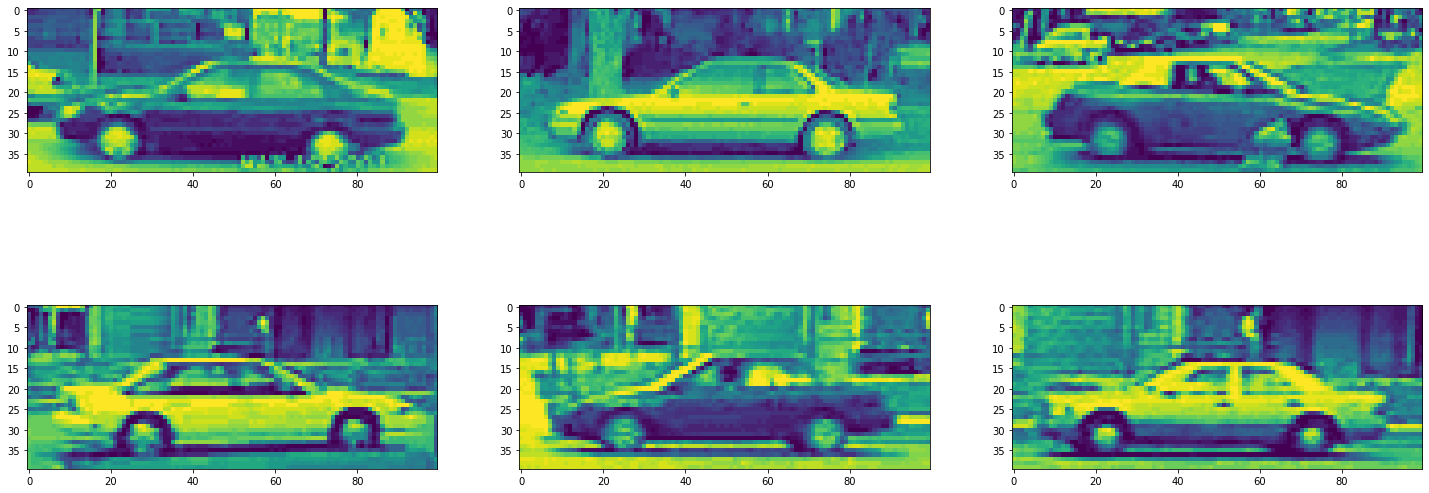

In [16]:
im_p1 = Image.open('./TrainImages/pos-392.pgm')
im_p2 = Image.open('./TrainImages/pos-393.pgm')
im_p3 = Image.open('./TrainImages/pos-394.pgm')
im_p4 = Image.open('./TrainImages/pos-395.pgm')
im_p5 = Image.open('./TrainImages/pos-396.pgm')
im_p6 = Image.open('./TrainImages/pos-397.pgm')
im_p1 = np.asarray(im_p1)
im_p2 = np.asarray(im_p2)
im_p3 = np.asarray(im_p3)
im_p4 = np.asarray(im_p4)
im_p5 = np.asarray(im_p5)
im_p6 = np.asarray(im_p6)

fig=plt.figure(figsize=(25,10))
fig.add_subplot(2, 3, 1)
imshow(im_p1)
fig.add_subplot(2, 3, 2)
imshow(im_p2)
fig.add_subplot(2, 3, 3)
imshow(im_p3)
fig.add_subplot(2, 3, 4)
imshow(im_p4)
fig.add_subplot(2, 3, 5)
imshow(im_p5)
fig.add_subplot(2, 3, 6)
imshow(im_p6)

print("The size of the testing images are", im_p1.shape[1], "by", im_p1.shape[0])

These are images with label **1** (images of cars).

Note that the images in the dataset are **grey scaled** and have relatively **low resolution (100 * 40)** 

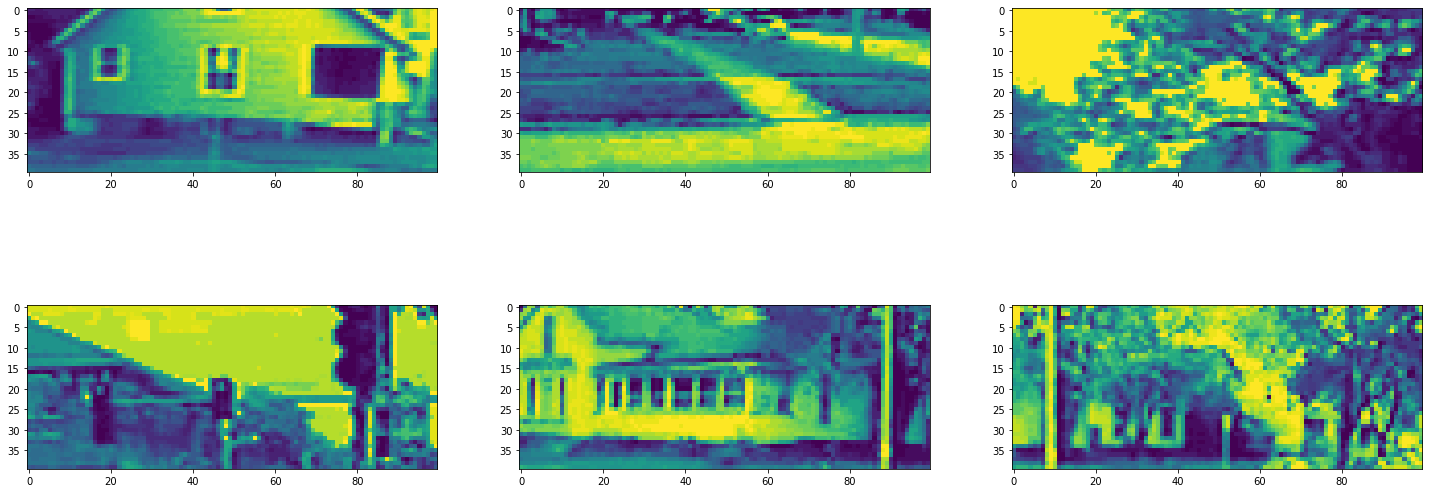

In [18]:
im_n1 = Image.open('./TrainImages/neg-392.pgm')
im_n2 = Image.open('./TrainImages/neg-393.pgm')
im_n3 = Image.open('./TrainImages/neg-394.pgm')
im_n4 = Image.open('./TrainImages/neg-325.pgm')
im_n5 = Image.open('./TrainImages/neg-396.pgm')
im_n6 = Image.open('./TrainImages/neg-399.pgm')
im_n1 = np.asarray(im_n1)
im_n2 = np.asarray(im_n2)
im_n3 = np.asarray(im_n3)
im_n4 = np.asarray(im_n4)
im_n5 = np.asarray(im_n5)
im_n6 = np.asarray(im_n6)

fig=plt.figure(figsize=(25,10))
fig.add_subplot(2, 3, 1)
imshow(im_n1)
fig.add_subplot(2, 3, 2)
imshow(im_n2)
fig.add_subplot(2, 3, 3)
imshow(im_n3)
fig.add_subplot(2, 3, 4)
imshow(im_n4)
fig.add_subplot(2, 3, 5)
imshow(im_n5)
fig.add_subplot(2, 3, 6)
imshow(im_n6)

These are six images with label **0** (images without cars).

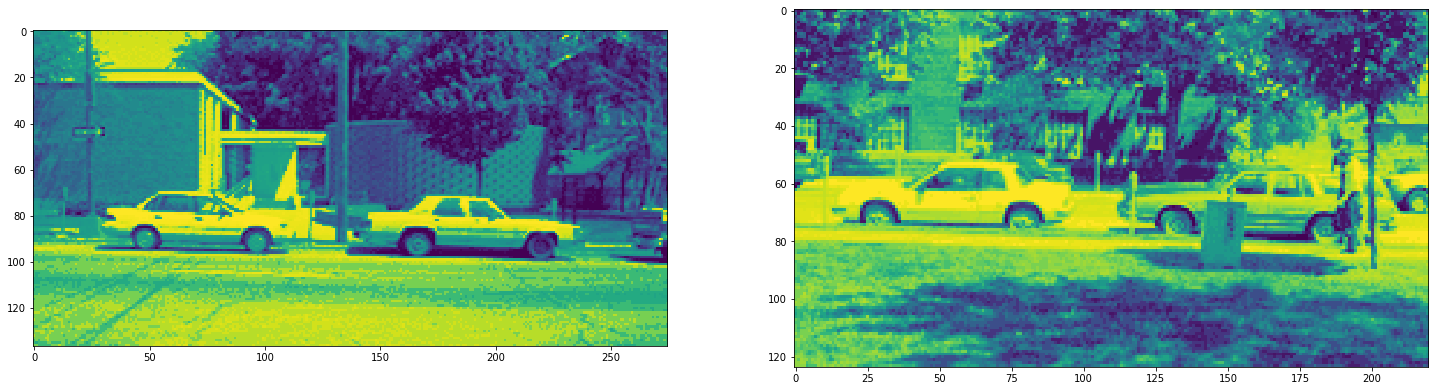

In [20]:
im_t1 = Image.open('./testCar/test-1.pgm')
im_t2 = Image.open('./testCar/test-4.pgm')
im_t1 = np.asarray(im_t1)
im_t2 = np.asarray(im_t2)

fig=plt.figure(figsize=(25,10))
fig.add_subplot(1, 2, 1)
imshow(im_t1)
fig.add_subplot(1, 2, 2)
imshow(im_t2)


The testing images are larger, with more complicated scenes. There are possibly more cars to detect in a single image.

We also find that the cars in the dataset are pretty **old**, which may **not fit the cars in recent year** well. But they can still be trained to detect the cars in similar styles like the testing picture above.

<a id="3"></a>
## 3. Model preparation
[back to top](#head)

<a id="3.1"></a>
### 3.1. Load images

In [27]:
def load_images(img_path, width, height):
    '''
    Function to read patch of grey scaled images from the target folder.
    
    img_path: string. the path to the image folder
    width: int. the width of the target imge
    height: int. the height of the target imge
    '''
    
    img_folder = img_path
    imlist = os.listdir(img_folder)
    imlist.sort()
    size = (len(imlist))
    counter = 0
    label = np.zeros([size])
    pixels = np.zeros([size, width, height, 1])
    for imagename in imlist:   
        imurl = os.path.join(img_folder,imagename)
        im = Image.open(imurl)
        for i in range(100):
            for j in range(40):
                gray = im.getpixel((i, j))
                pixels[counter, i, j, 0] = gray
        if imagename[0] == 'n':
            label[counter] = 0
        else:
            label[counter] = 1
        counter = counter + 1 
    pixels = pixels.transpose(0,2,1,3)
    return (pixels, label)

In [28]:
(pixels, label) = load_images("./TrainImages", 100, 40)
count_neg = sum(label==0)
count_pos = sum(label==1)
print("There are", count_pos, "positive samples (i.e. pictures with cars) in the dataset.")
print("There are", count_neg, "negative samples (i.e. pictures without cars) in the dataset.")

There are 550 positive samples (i.e. pictures with cars) in the dataset.
There are 500 negative samples (i.e. pictures without cars) in the dataset.


So the data is pretty balanced with label 0 and 1. But the amount of samples may be insufficient for training.

In [29]:
pixels.shape

(1050, 40, 100, 1)

<a id="3.2"></a>
### 3.2. Split training and testing set

Now we split the train and test dataset before setting up the CNN.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(pixels, label, test_size=0.2, random_state=82)

Our labels now still contain integers 0 and 1, we need to turn them to **categorical labels** before training.

In [31]:
y_train = to_categorical(y_train, 2)
#y_test = to_categorical(y_test, 2)

The following lines **rescale** the grey scale values from **0~255** to **0~1**.

In [32]:
X_train = X_train/255
X_test = X_test/255

<a id="4"></a>
## 4. Model and tuning
[back to top](#head)

<a id="4.1"></a>
### 4.1. Create and train CNN model

In our CNN model, we first feed the pixels into two 2d convolution layers, with 40 and 80 3$*$3-sized filters. Each of them is followed by a 2$*$2 maxpooling layer. Then after flattening the tensors, we connect them to a fully connected neuron network with 3 hidden layers. We also add three dropout layers to avoid overfitting.

In [146]:
model = Sequential()
model.add(Conv2D(40, 3, 3, input_shape=(40,100,1)))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Conv2D(80,3,3))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Flatten())
model.add(Dense(units=400, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=400, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=400, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['acc'])

In [147]:
model.fit(X_train, y_train, batch_size=20, epochs=20)

Train on 840 samples
Epoch 1/20
840/840 [==============================] - 1s 1ms/sample - loss: 0.5658 - acc: 0.6643
Epoch 2/20
840/840 [==============================] - 1s 781us/sample - loss: 0.3012 - acc: 0.8738
Epoch 3/20
840/840 [==============================] - 1s 783us/sample - loss: 0.1300 - acc: 0.9512
Epoch 4/20
840/840 [==============================] - 1s 772us/sample - loss: 0.0832 - acc: 0.9679
Epoch 5/20
840/840 [==============================] - 1s 779us/sample - loss: 0.0469 - acc: 0.9774
Epoch 6/20
840/840 [==============================] - 1s 814us/sample - loss: 0.0298 - acc: 0.9905
Epoch 7/20
840/840 [==============================] - 1s 777us/sample - loss: 0.0172 - acc: 0.9929
Epoch 8/20
840/840 [==============================] - 1s 773us/sample - loss: 0.0025 - acc: 1.0000
Epoch 9/20
840/840 [==============================] - 1s 788us/sample - loss: 0.0026 - acc: 0.9988
Epoch 10/20
840/840 [==============================] - 1s 785us/sample - loss: 2.2574e-04 

<a id="4.2"></a>
### 4.2. Evaluate model

We use the **confusion matrix** and **f1 score** to evaluate the classification performance of our model.

In [149]:
predicted = model.predict_classes(X_test)
print('----------------'*3)
print(confusion_matrix(predicted, y_test))
print('----------------'*3)
print(classification_report(predicted, y_test))

------------------------------------------------
[[ 90   2]
 [  5 113]]
------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        92
           1       0.98      0.96      0.97       118

    accuracy                           0.97       210
   macro avg       0.96      0.97      0.97       210
weighted avg       0.97      0.97      0.97       210



The model correctly predicts more than **96%** of the testing set. 

Now we output these seven wrongly classified images to discuss the potential reasons they were mis-classified.

Text(0.5, 0.98, 'False Negative')

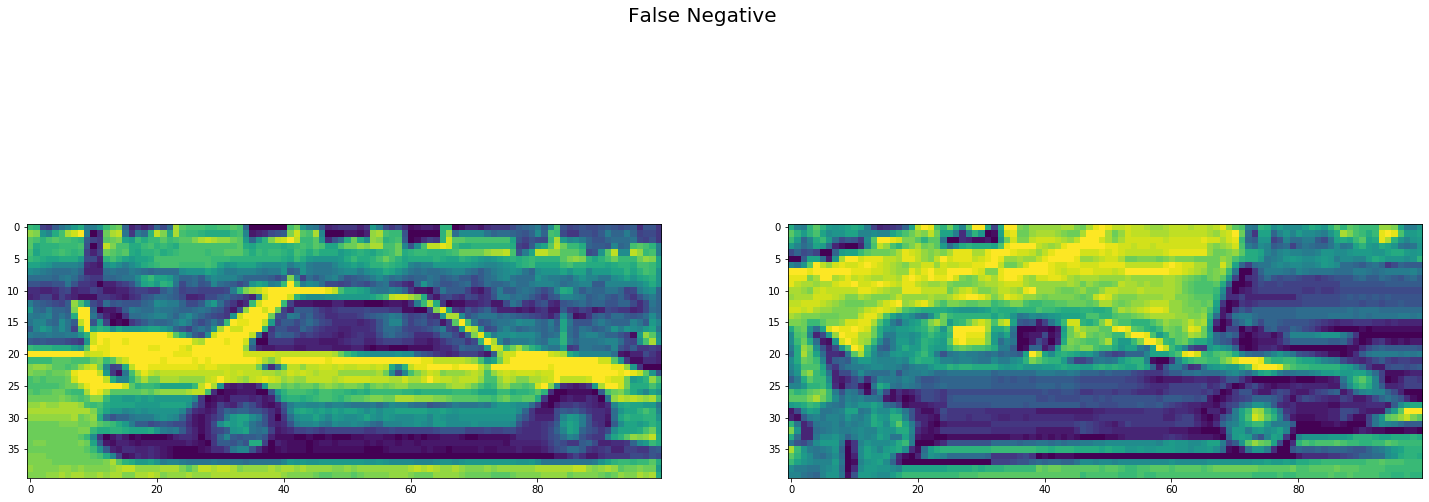

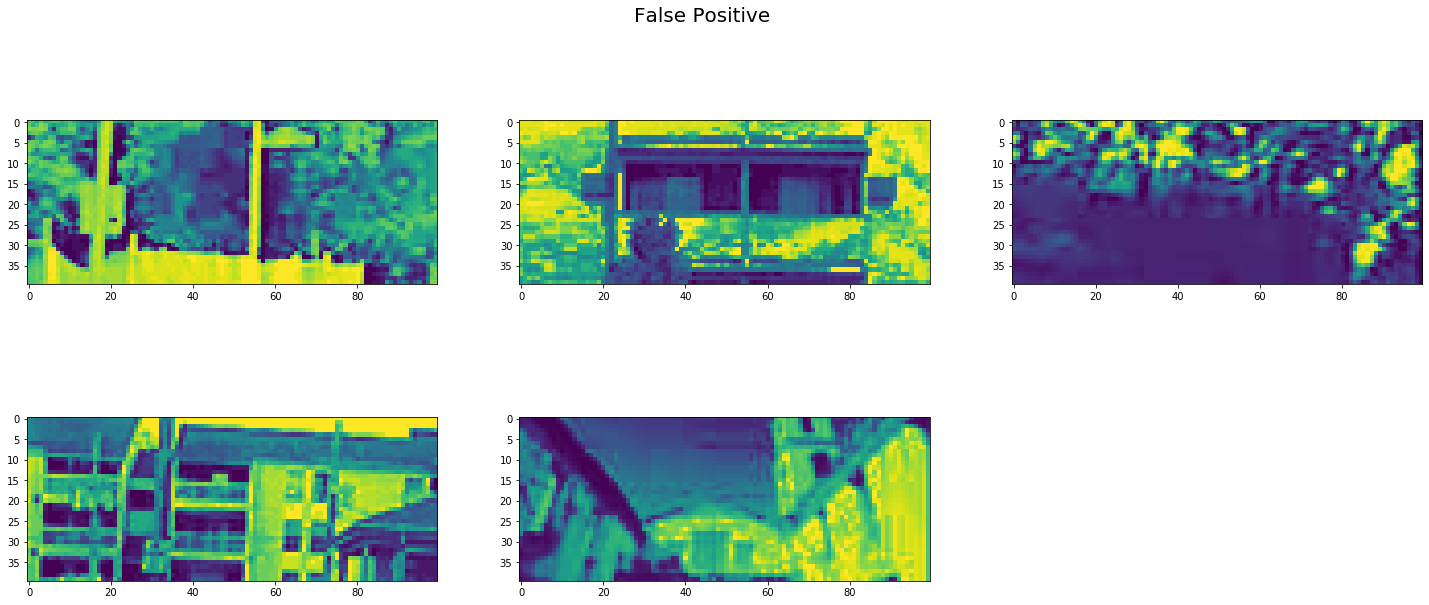

In [151]:
counter_neg = 1
counter_pos = 1

fig_neg=plt.figure(figsize=(25,10))
for i in range (X_test.shape[0]):
    if (y_test[i]==1 and predicted[i]==0):
        fasle = (X_test[i]*255).reshape(40,100)
        fig_neg.add_subplot(1, 2, counter_neg)
        counter_neg = counter_neg + 1
        imshow(fasle)
fig_pos=plt.figure(figsize=(25,10))
for i in range (X_test.shape[0]):
    if (y_test[i]==0 and predicted[i]==1):
        fasle = (X_test[i]*255).reshape(40,100)
        fig_pos.add_subplot(2, 3, counter_pos)
        counter_pos = counter_pos + 1
        imshow(fasle)
fig_pos.suptitle('False Positive', fontsize = 20)
fig_neg.suptitle('False Negative', fontsize = 20)

We can see that the images with windows (especially double windows) are likely to be wrongly classified as cars. As the contrast ratio of these images are relatively low, cars which share similar grey scale with surroundings are likely to be wrongly classified as no cars.

<a id="4.3"></a>
### 4.3. Car detection interface

Our final goal is to **find the cars** in the testing images. An simple way is to generate a **rectangle frame** with similar size as the car as the frame of study. Then we **scan** the image with this frame **horizontally and vertically with some step length**. In each step we **feed the image cut from the frame to our trained CNN**, which predicts whether there is a car in the frame. At last we **draw the frames activated by CNN**. Hopefully all cars will be captures in the frames.

I have to admit it is a **bad idea** compared to more advanced model such as YOLO. The speed is **far lower than YOLO** as we need predictions from CNN many times (more times when the step length is smaller). Also, as the size of the frame is fixed, this model is very **sensitive to the size of the car**, indicating that the cars need to be as similar size as the cars in the training set to be detected.

Anyway, it is better than nothing, LOL.

In [100]:
def cutting(x, y):
    '''
    The funtion take the starting cordinate (x, y) as input, 
    and return the area of study (a 2d numpy array).
    '''
    area_study = np.arange(100*40).reshape(1, 40, 100, 1)
    for i in range(40):
        for j in range(100):
            area_study[0][i][j][0] = picture_tensor[0][x+i][y+j][0]
    #plt.imshow(area_study)
    #plt.show()
    #area_study = area_study.transpose([0,1,2])
    area_study = area_study / 255
    #sys.stdout.write('\rX:{0} Y:{1}  '.format(x, y))
    return area_study

In [101]:
def not_near(x, y, s, coordinates):
    '''
    This function help set a boundary ('s') between frames to avoid the repeated frames drawn on one car.
    It return a boolean value to judge whether there is already a frame nearby ('x', 'y'), from the frames already stored in 'coordinates'.
    '''
    result = True
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result

In [102]:
def show_car(x, y, width, height, thickness=1): 
    '''
    This function draw a rectangle, which start from ('x', 'y') with 'width', 'height' and 'thickness'.
    '''
    for i in range(40):
        for th in range(thickness):
            picture_tensor[0][x+i][y-th][0] = -1

    for i in range(40):
        for th in range(thickness):
            if y+th+100 < width:
                picture_tensor[0][x+i][y+th+100][0] = -1
            else:
                picture_tensor[0][x+i][width - 1][0] = -1
        
    for i in range(100):
        for th in range(thickness):
            picture_tensor[0][x-th][y+i][0] = -1
        
    for i in range(100):
        for th in range(thickness):
            if x+th+40 < height:
                picture_tensor[0][x+th+40][y+i][0] = -1
            else:
                picture_tensor[0][height-1][y+i][0] = -1

<a id="5"></a>
## 5. Test and conclusion
[back to top](#head)

Let's test it on a single image first.

Find a car with 100.0 percent certainty.


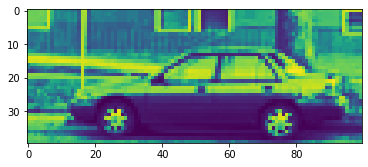

Find a car with 99.99903440475464 percent certainty.


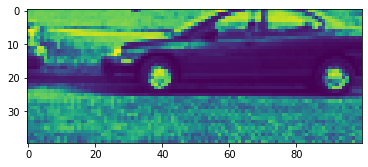

In [157]:
im_test = Image.open('./testCar/test-3.pgm')
width = im_test.size[0]
height = im_test.size[1]
picture_tensor = np.zeros([1, width, height, 1])
for i in range(width):
    for j in range(height):
        gray = im_test.getpixel((i, j))
        picture_tensor[0, i, j, 0] = gray
picture_tensor = picture_tensor.transpose(0,2,1,3)

step = 15
cars = []
for y in range(int((width-(100-step))/step)):
    for x in range(int((height-(40-step))/step)):
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][1]>0.9999 and not_near(x*step,y*step, 88, cars):
            cars.append([[x*step, y*step], result])
            print("Find a car with", result[0][1]*100, "percent certainty.")
            area = area.reshape(40,100)
            plt.imshow(area)
            plt.show()

Now we draw rectangles on the orginal image.

30 15
45 105


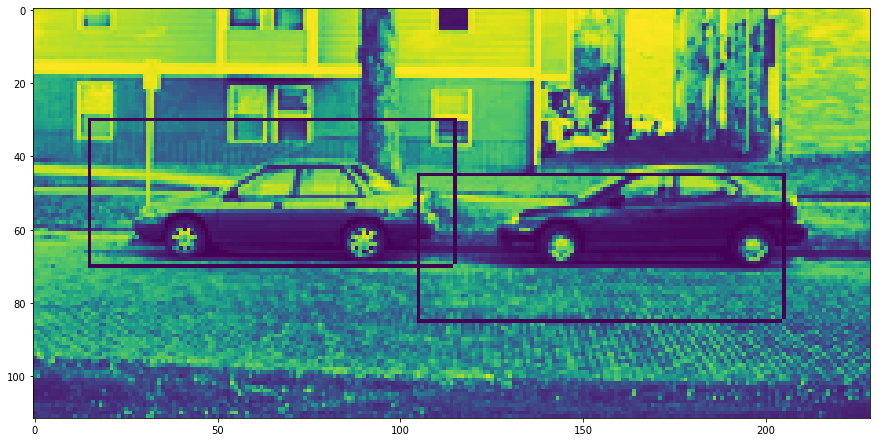

In [158]:
for i in cars:
    print(i[0][0], i[0][1])
    show_car(i[0][0], i[0][1], width, height)
    
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picture_tensor.reshape(height, width))

plt.show()

Now we use this model to detect the cars in the first 100 test images

Image No. 1
1 car(s) detected in this image


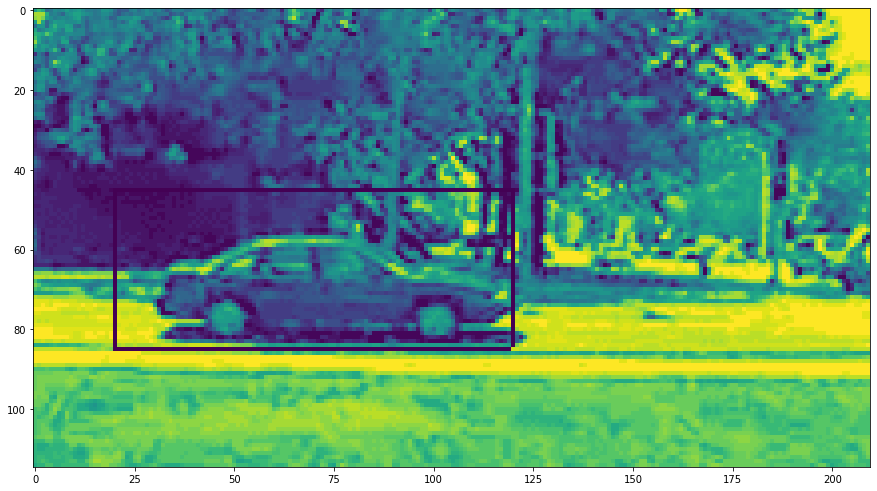

Image No. 2
2 car(s) detected in this image


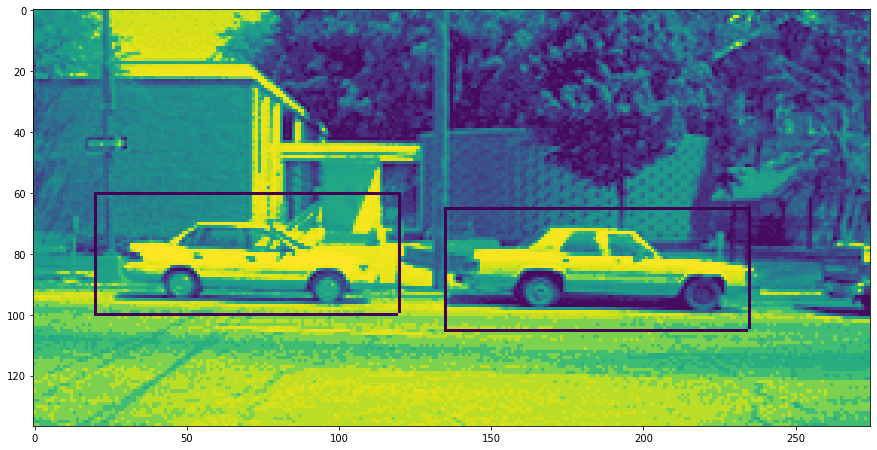

Image No. 3
2 car(s) detected in this image


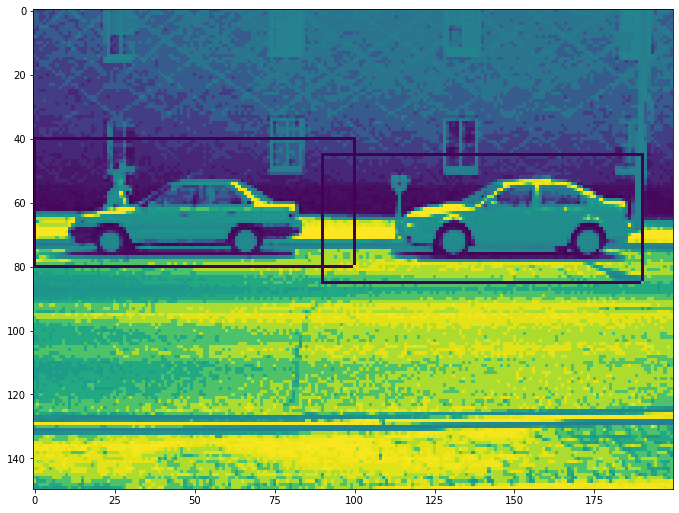

Image No. 4
1 car(s) detected in this image


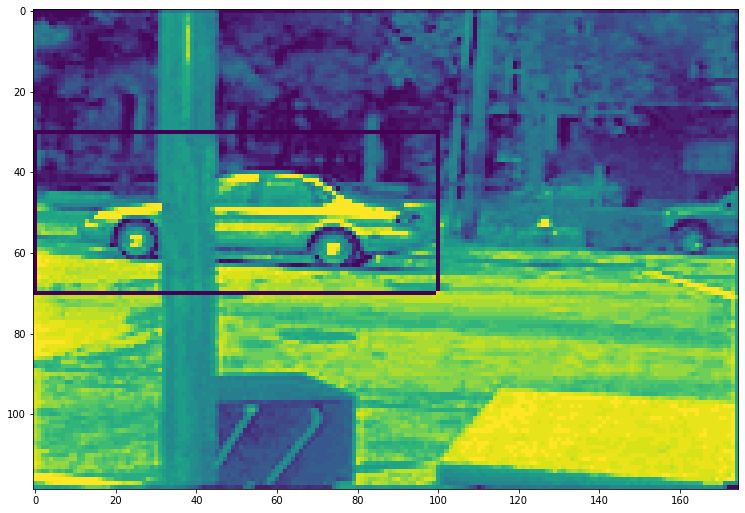

Image No. 5
2 car(s) detected in this image


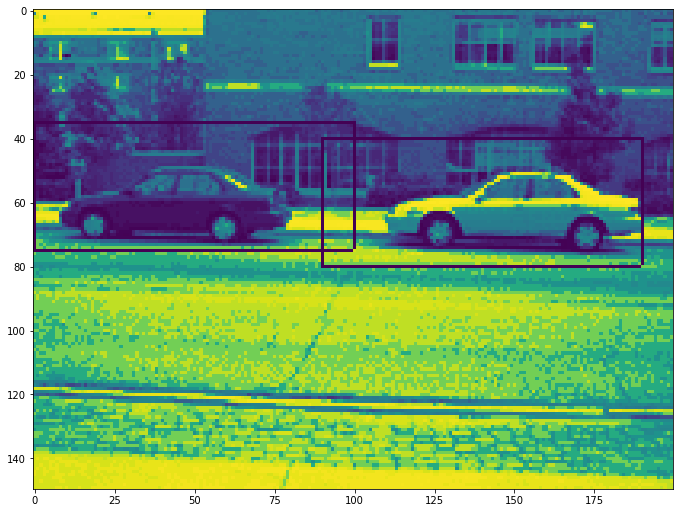

Image No. 6
1 car(s) detected in this image


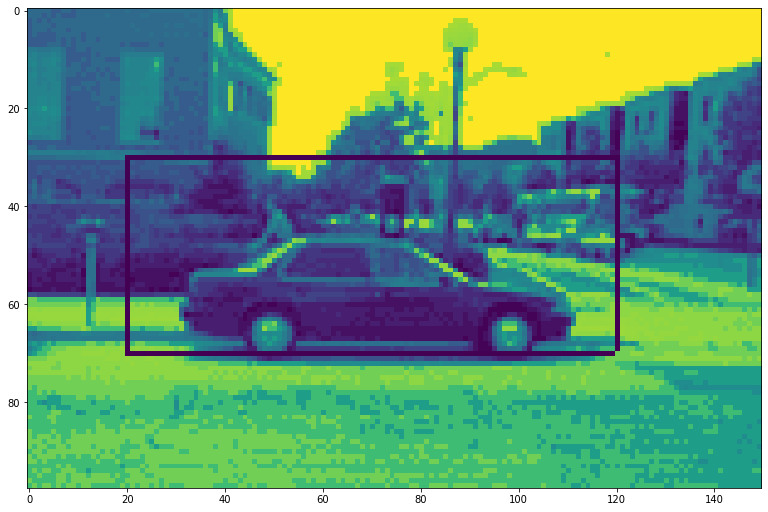

Image No. 7
1 car(s) detected in this image


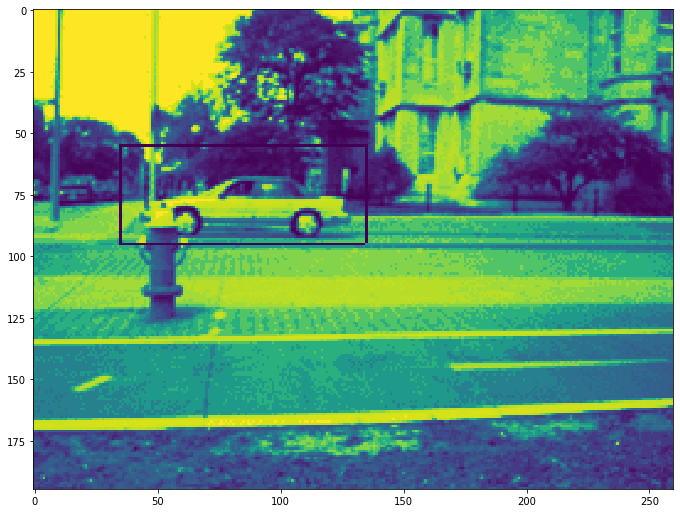

Image No. 8
1 car(s) detected in this image


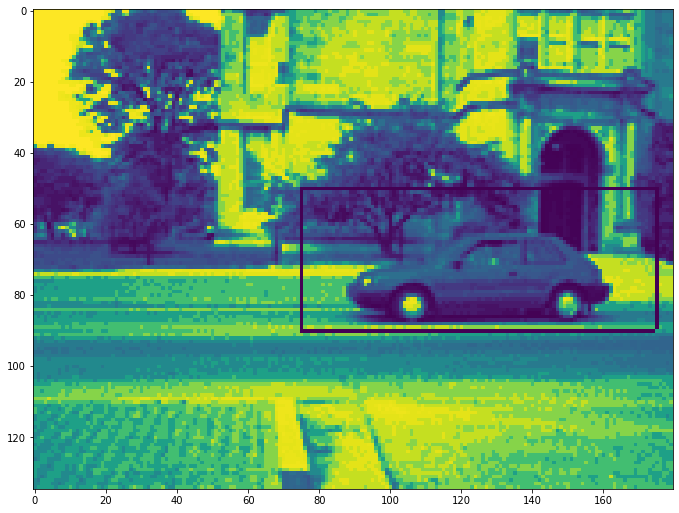

Image No. 9
3 car(s) detected in this image


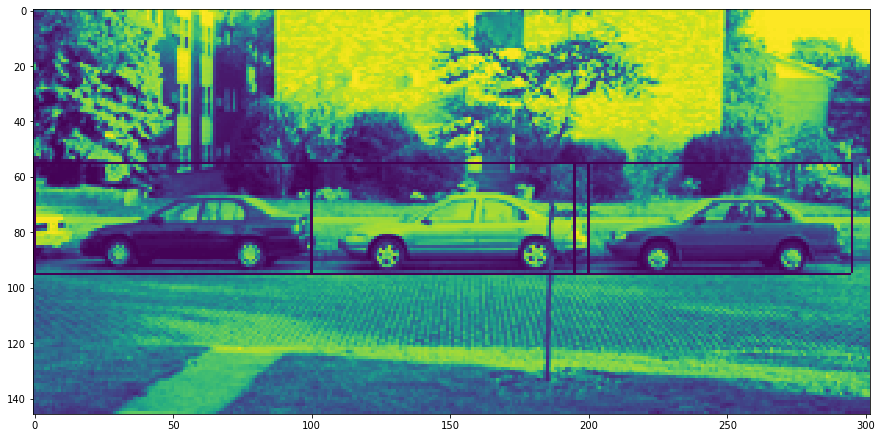

Image No. 10
1 car(s) detected in this image


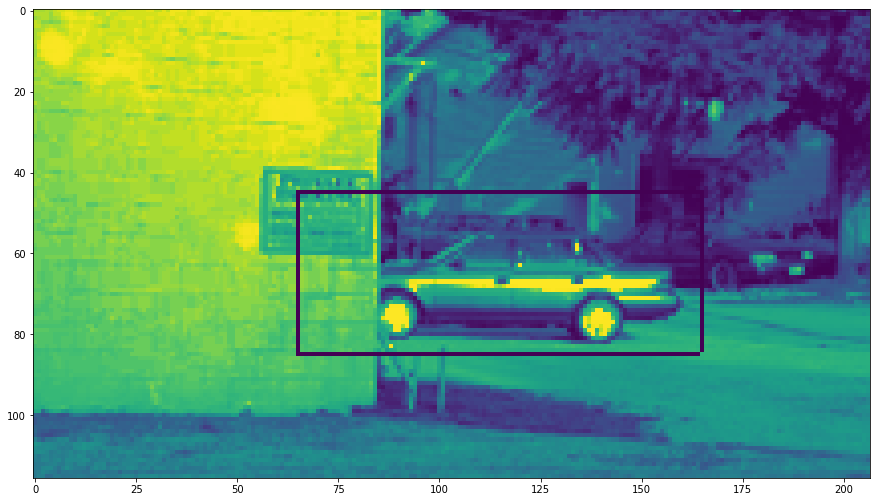

Image No. 11
0 car(s) detected in this image


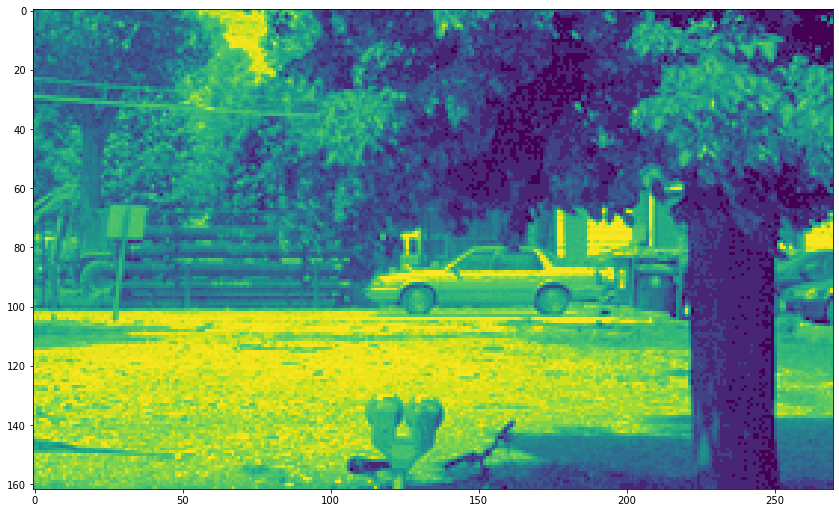

Image No. 12
0 car(s) detected in this image


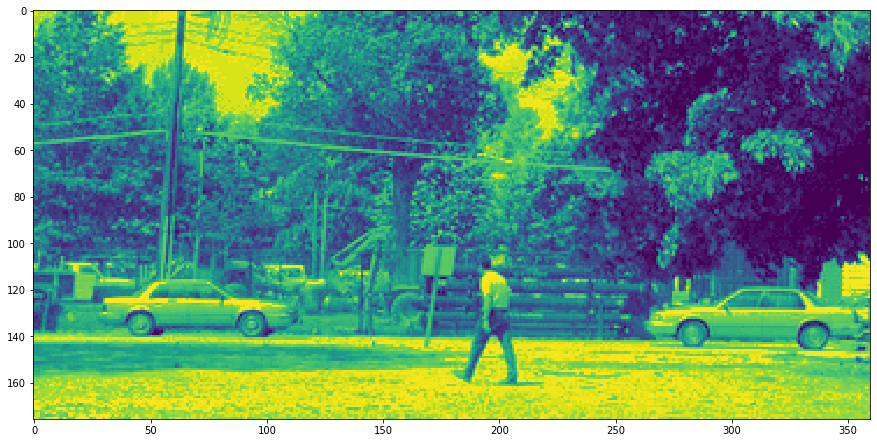

Image No. 13
0 car(s) detected in this image


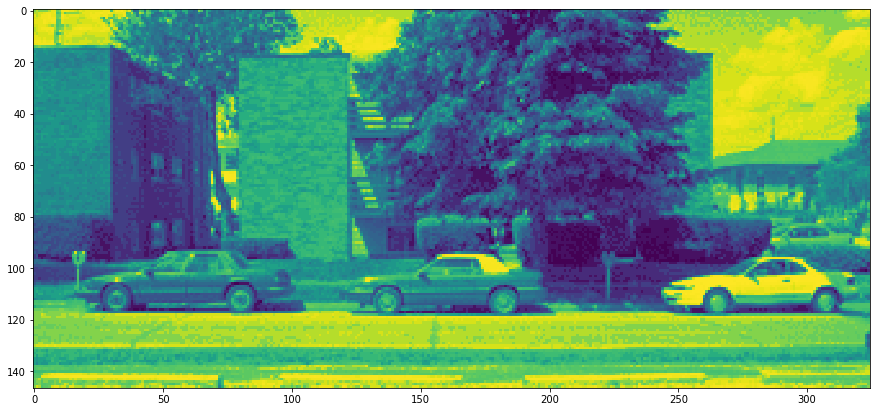

Image No. 14
1 car(s) detected in this image


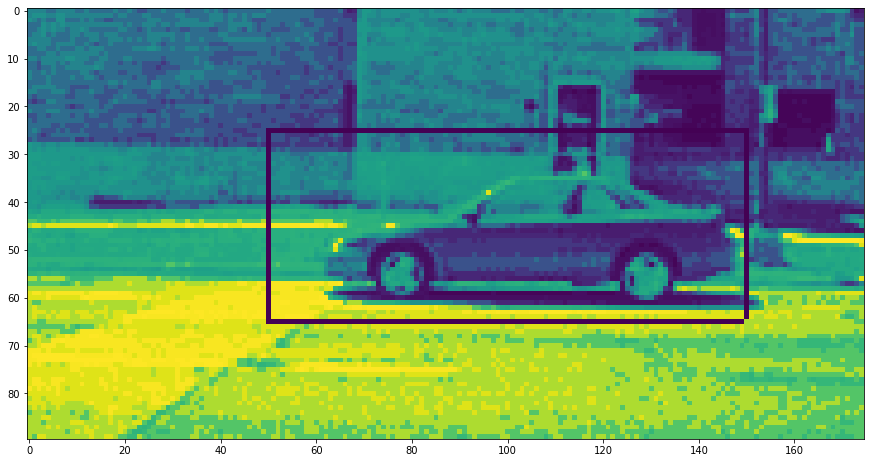

Image No. 15
1 car(s) detected in this image


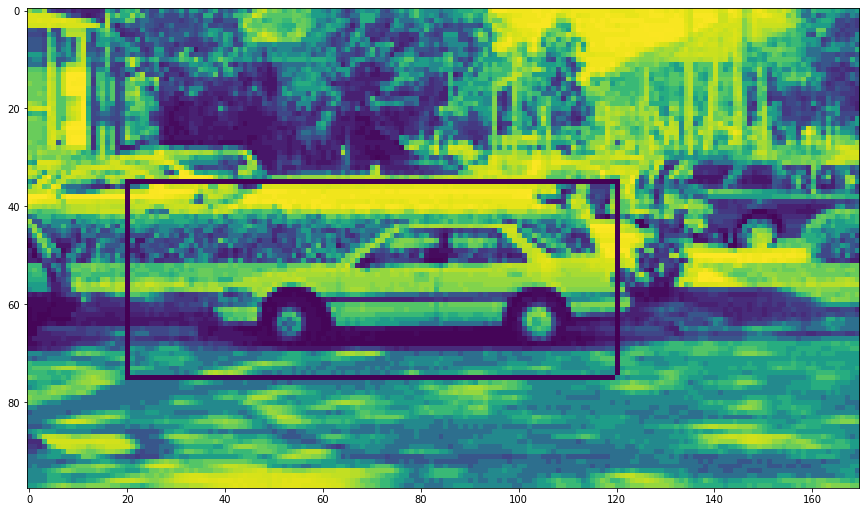

Image No. 16
0 car(s) detected in this image


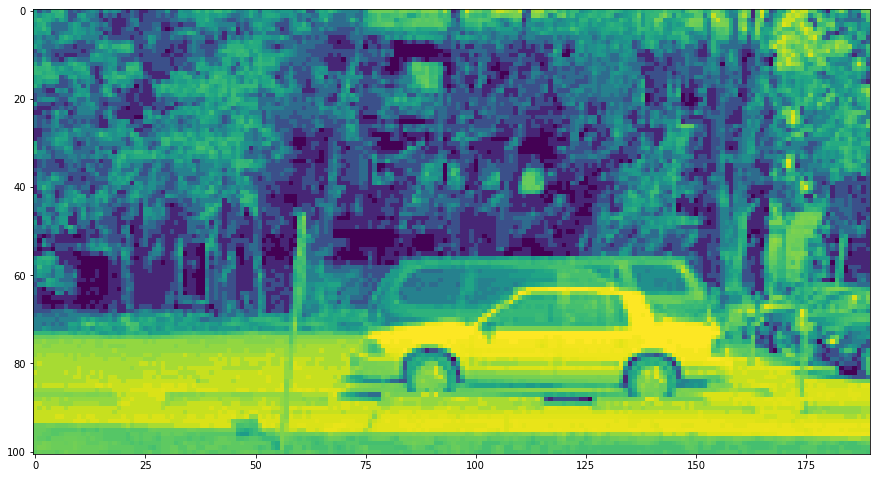

Image No. 17
1 car(s) detected in this image


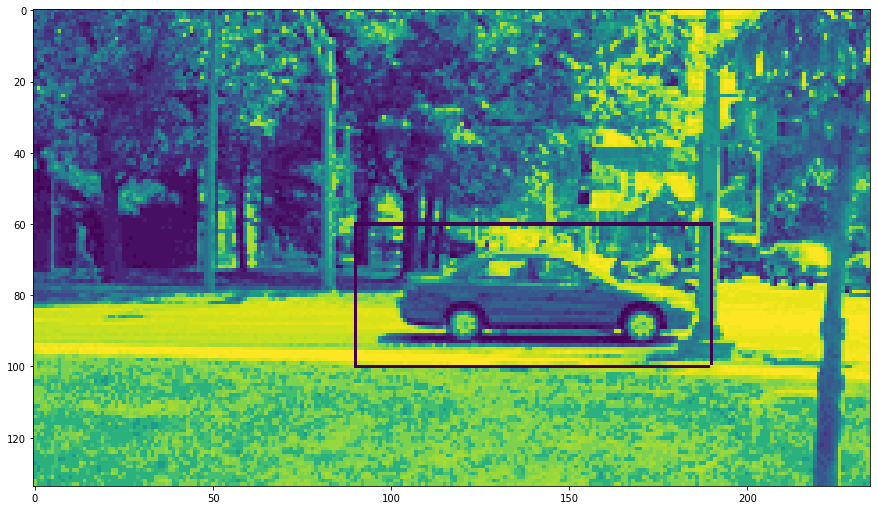

Image No. 18
0 car(s) detected in this image


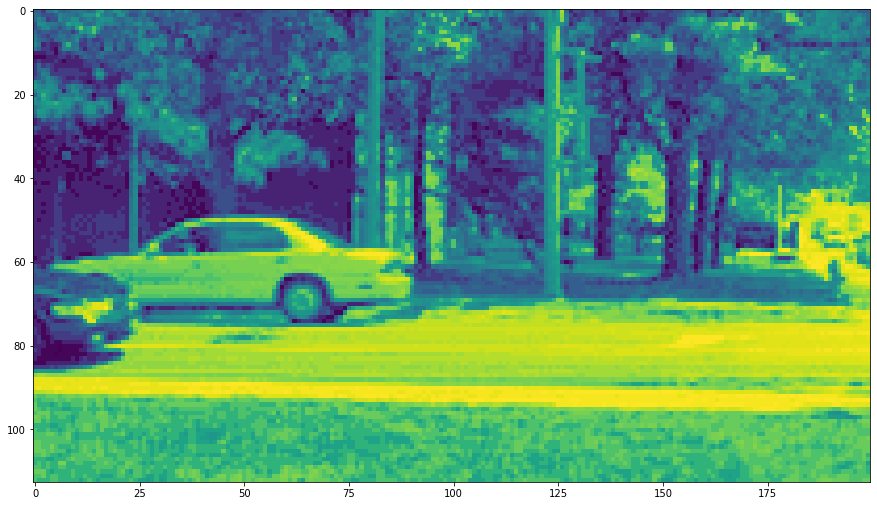

Image No. 19
0 car(s) detected in this image


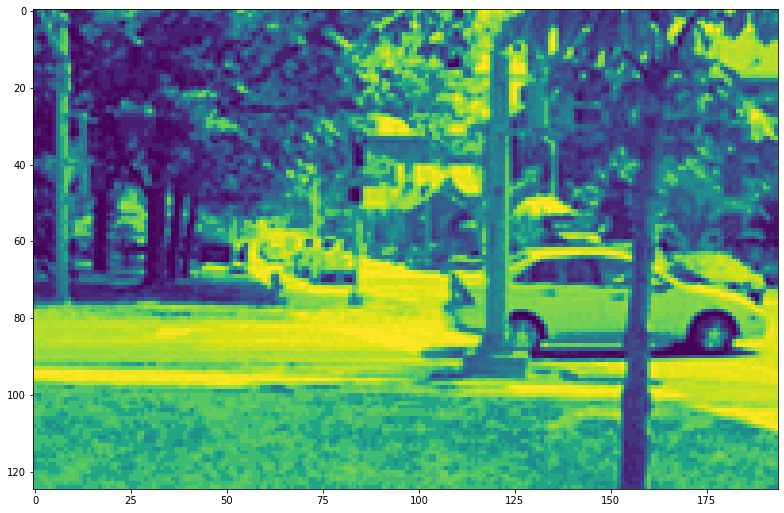

Image No. 20
1 car(s) detected in this image


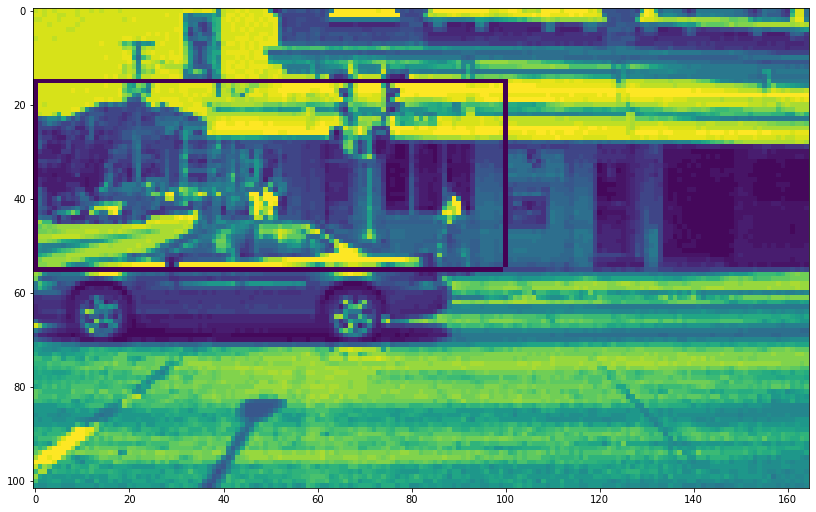

Image No. 21
2 car(s) detected in this image


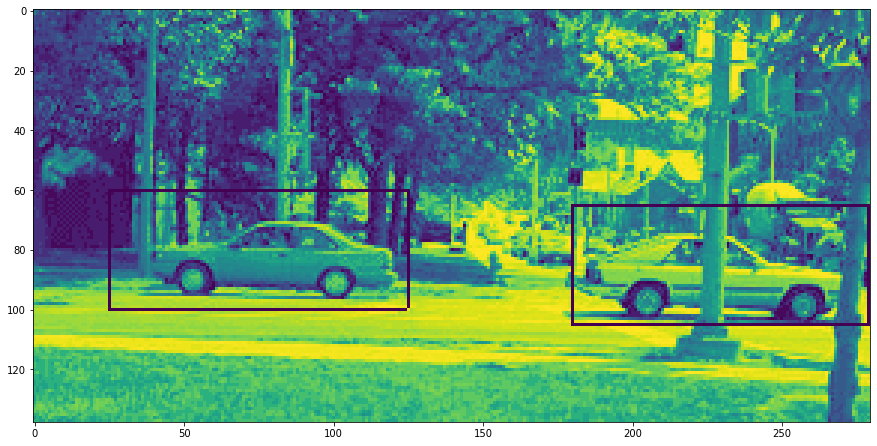

Image No. 22
1 car(s) detected in this image


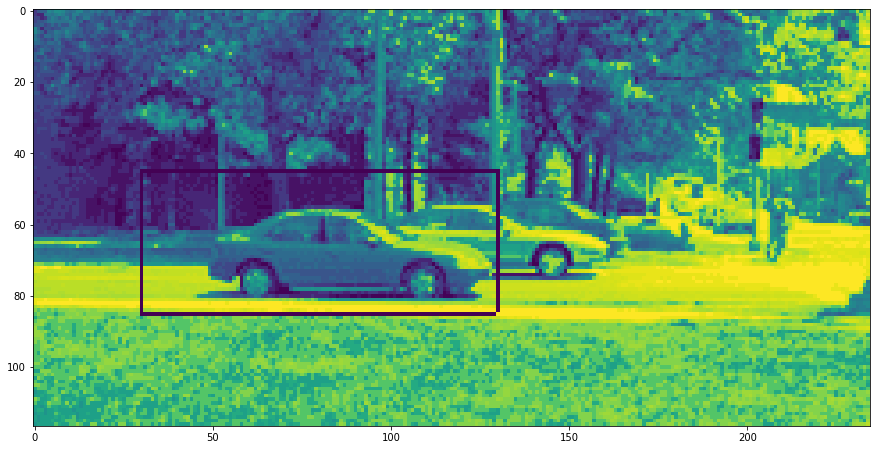

Image No. 23
1 car(s) detected in this image


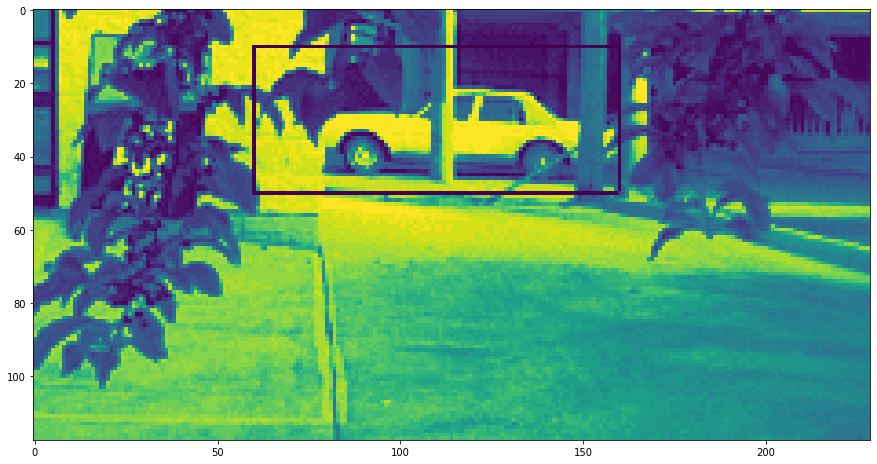

Image No. 24
1 car(s) detected in this image


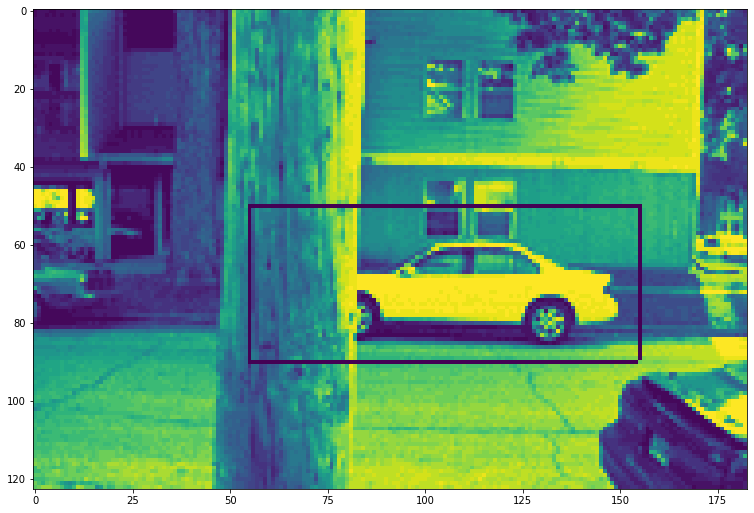

Image No. 25
2 car(s) detected in this image


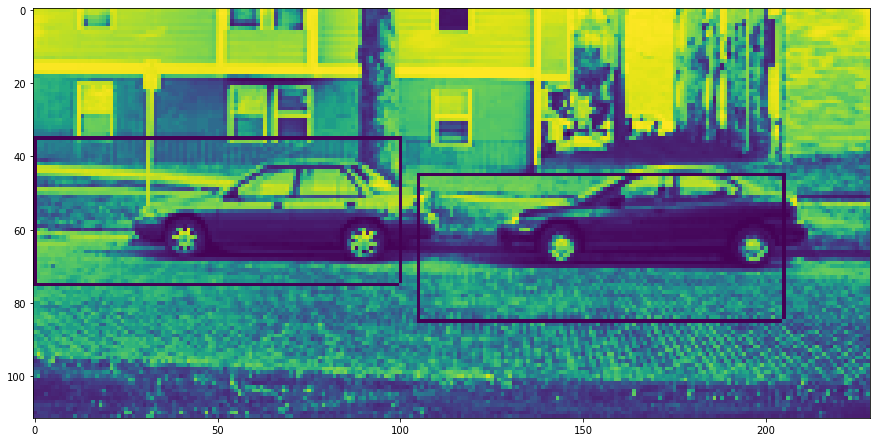

Image No. 26
1 car(s) detected in this image


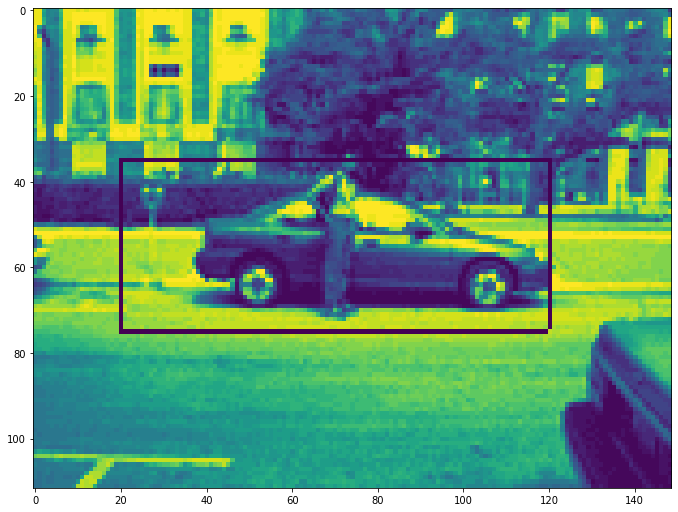

Image No. 27
1 car(s) detected in this image


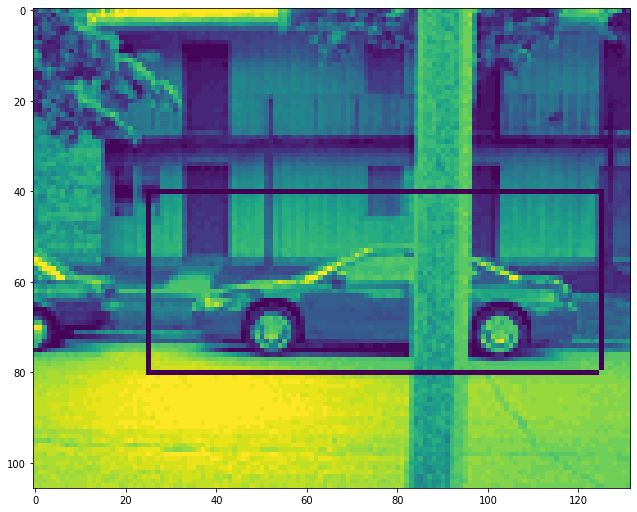

Image No. 28
2 car(s) detected in this image


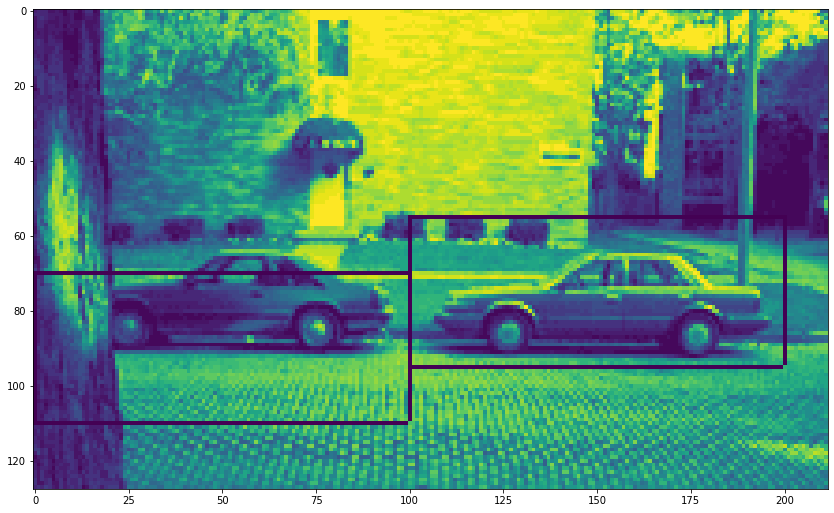

Image No. 29
0 car(s) detected in this image


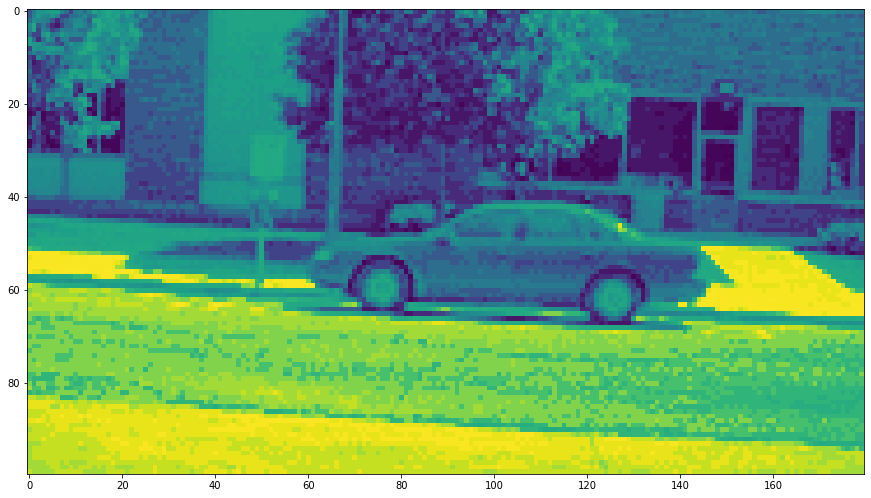

Image No. 30
1 car(s) detected in this image


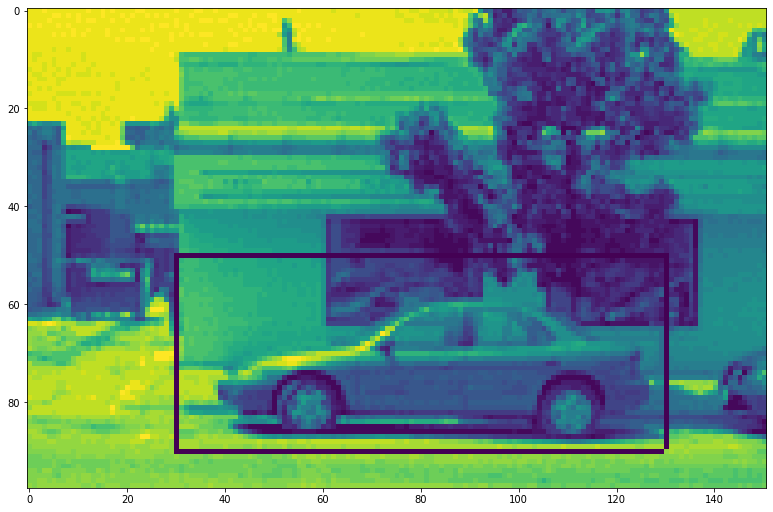

Image No. 31
1 car(s) detected in this image


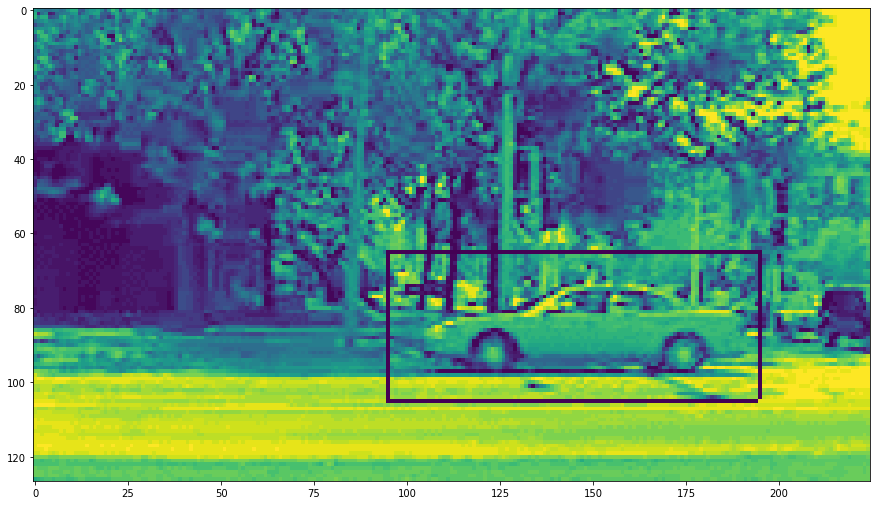

Image No. 32
1 car(s) detected in this image


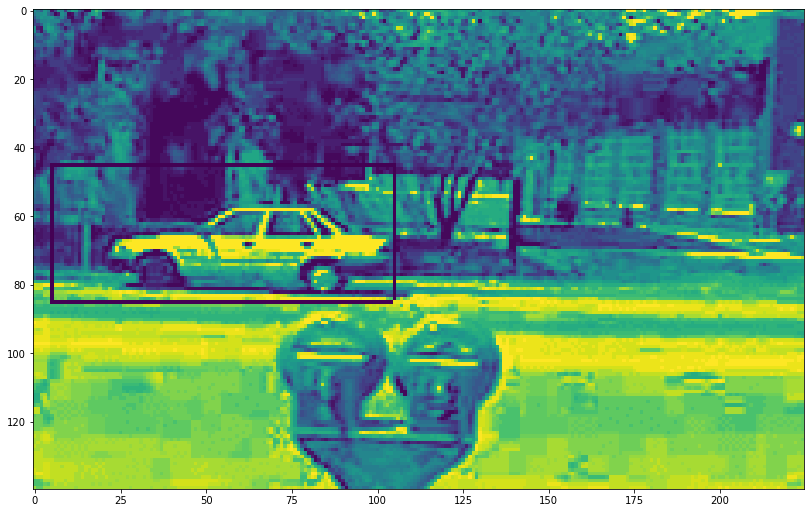

Image No. 33
1 car(s) detected in this image


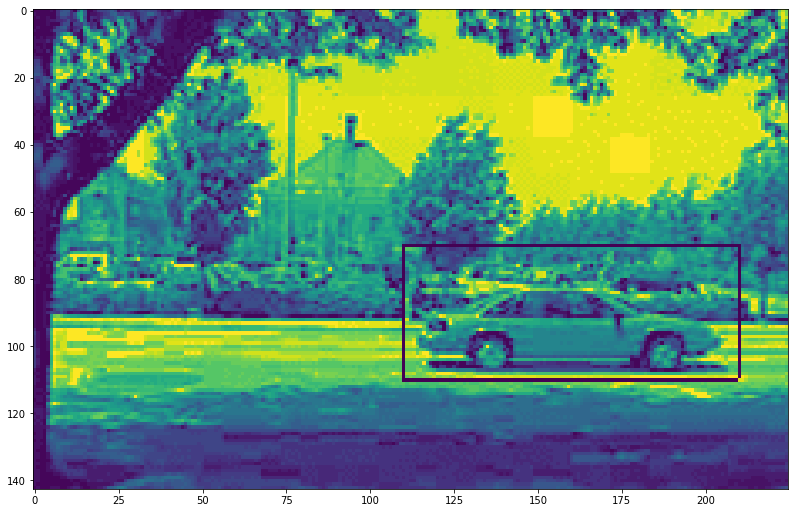

Image No. 34
1 car(s) detected in this image


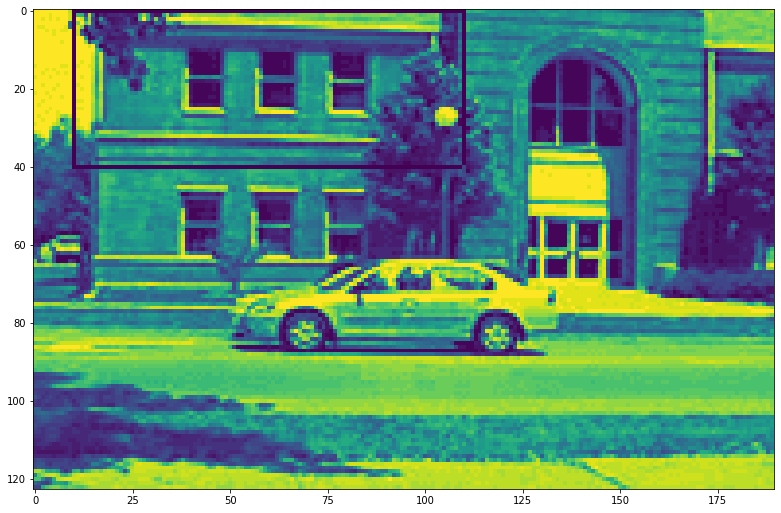

Image No. 35
1 car(s) detected in this image


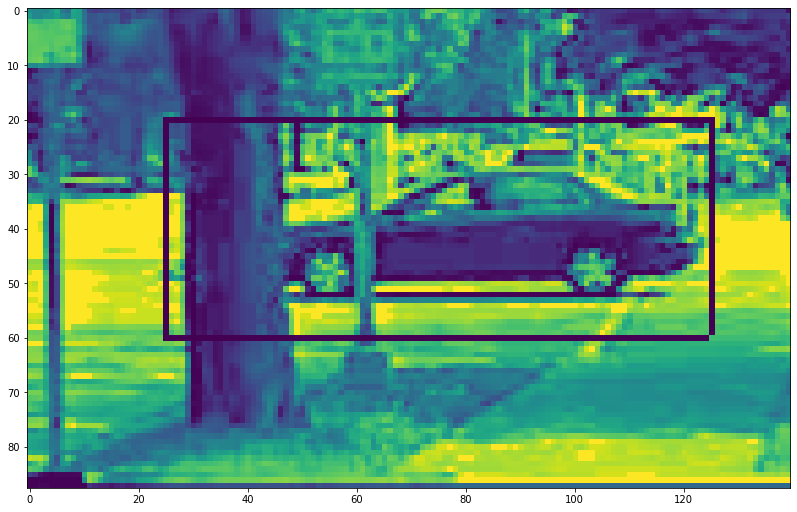

Image No. 36
1 car(s) detected in this image


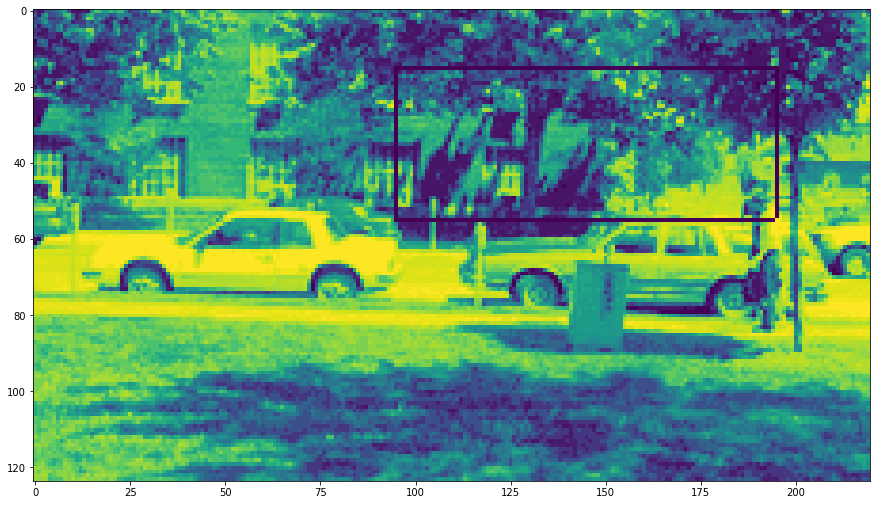

Image No. 37
2 car(s) detected in this image


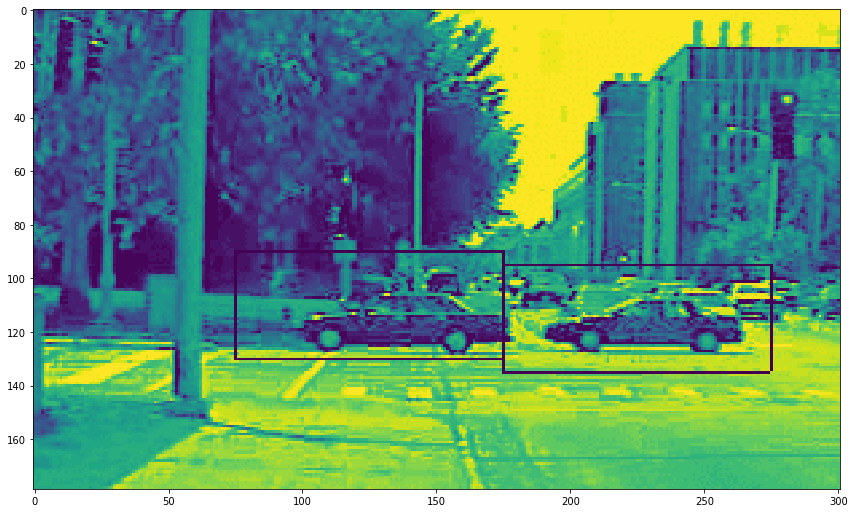

Image No. 38
1 car(s) detected in this image


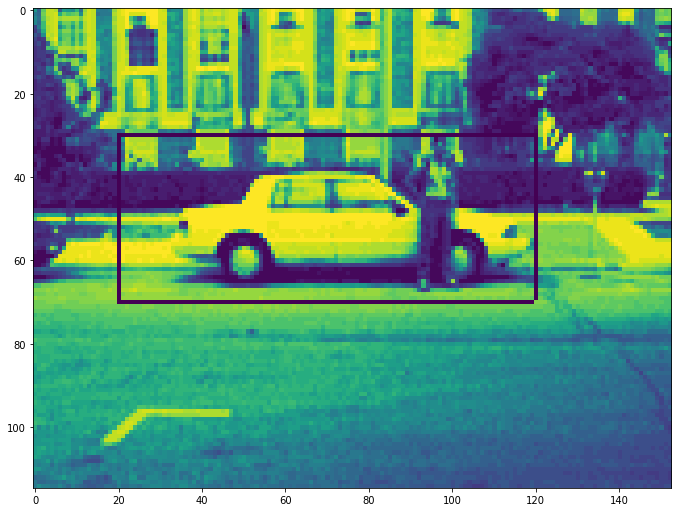

Image No. 39
1 car(s) detected in this image


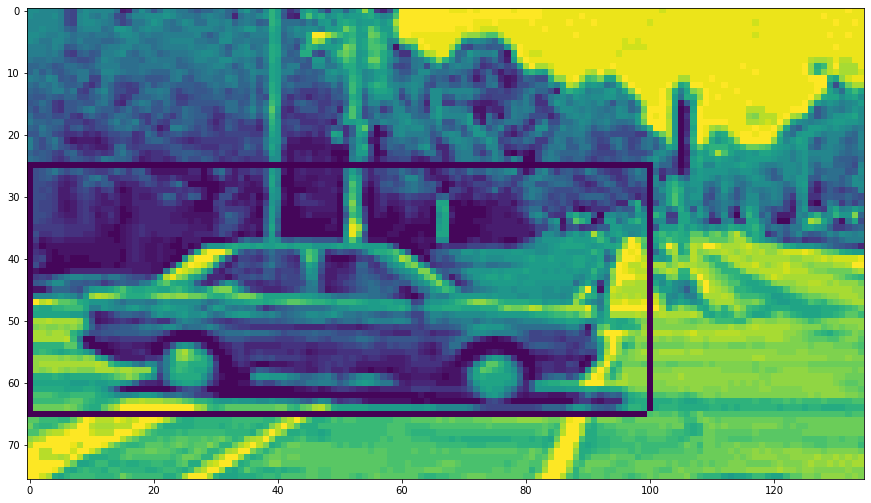

Image No. 40
1 car(s) detected in this image


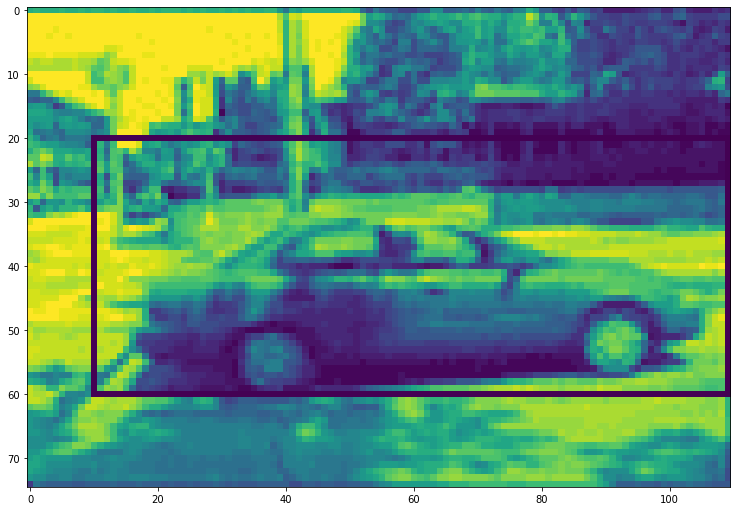

Image No. 41
1 car(s) detected in this image


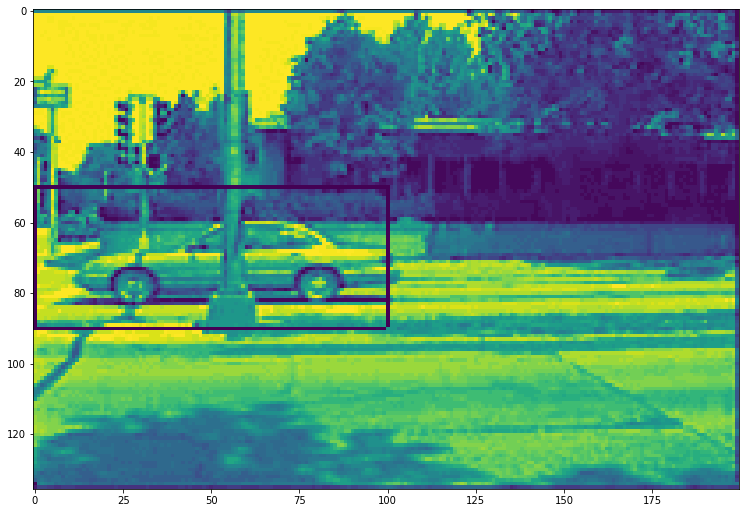

Image No. 42
1 car(s) detected in this image


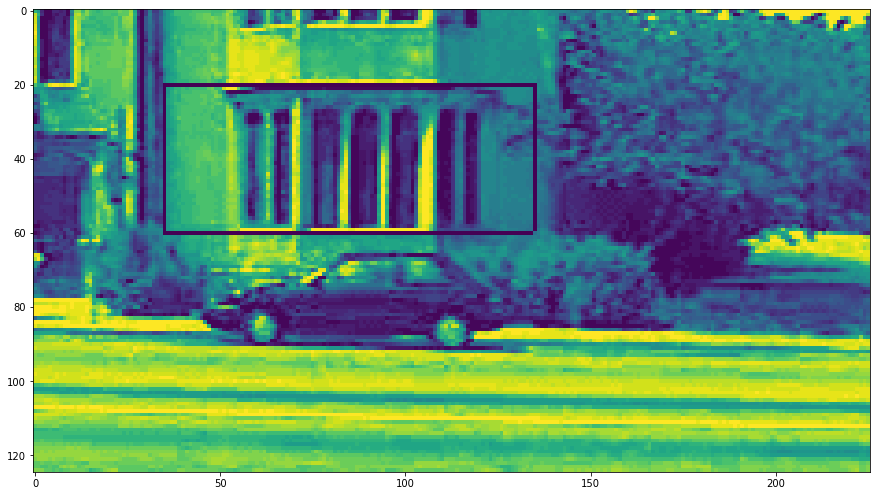

Image No. 43
2 car(s) detected in this image


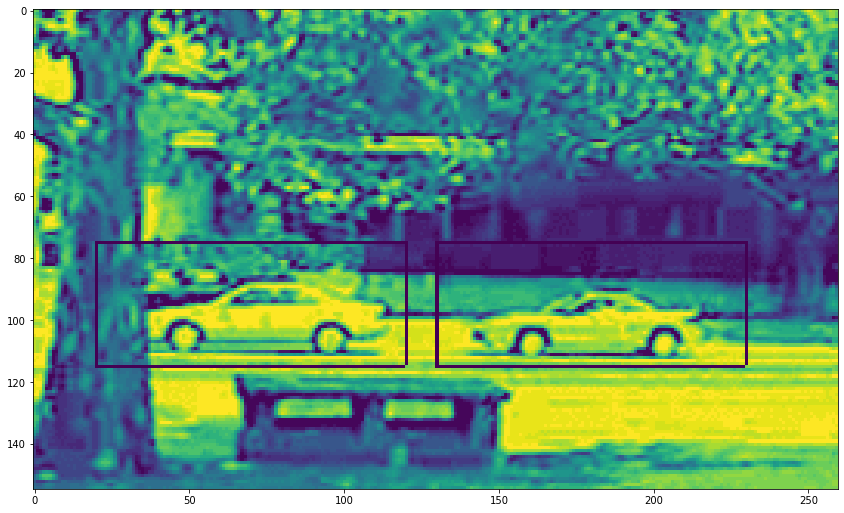

Image No. 44
1 car(s) detected in this image


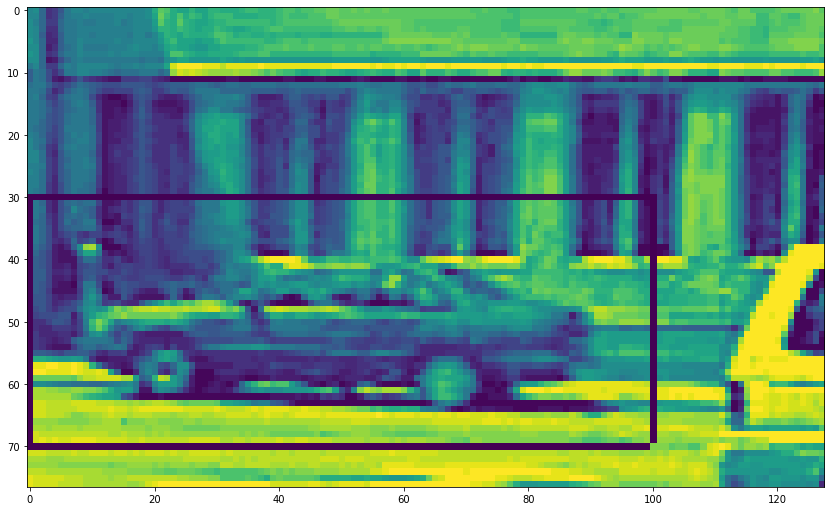

Image No. 45
1 car(s) detected in this image


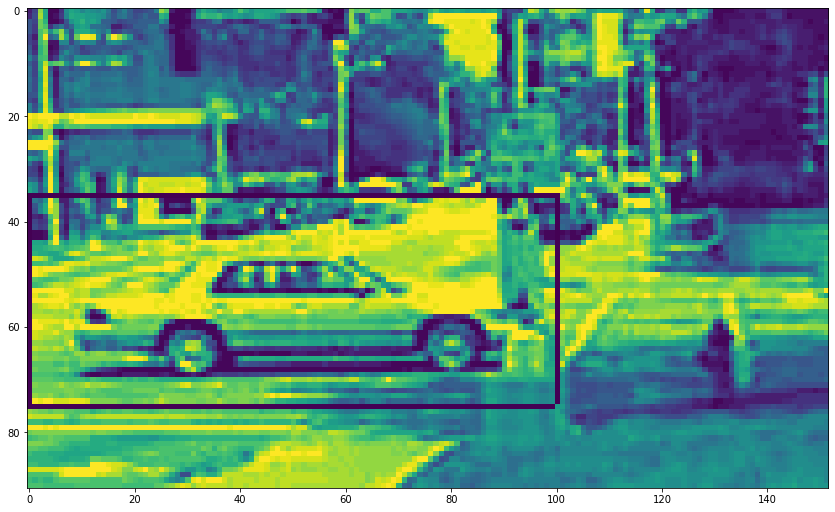

Image No. 46
1 car(s) detected in this image


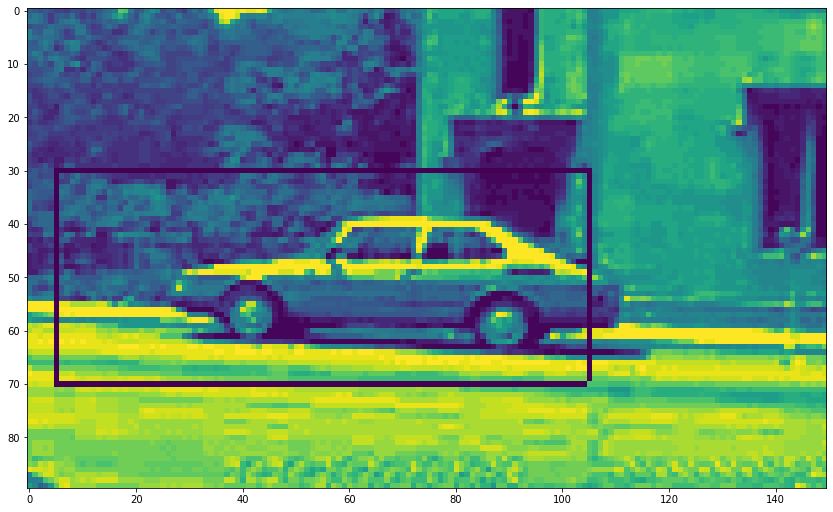

Image No. 47
1 car(s) detected in this image


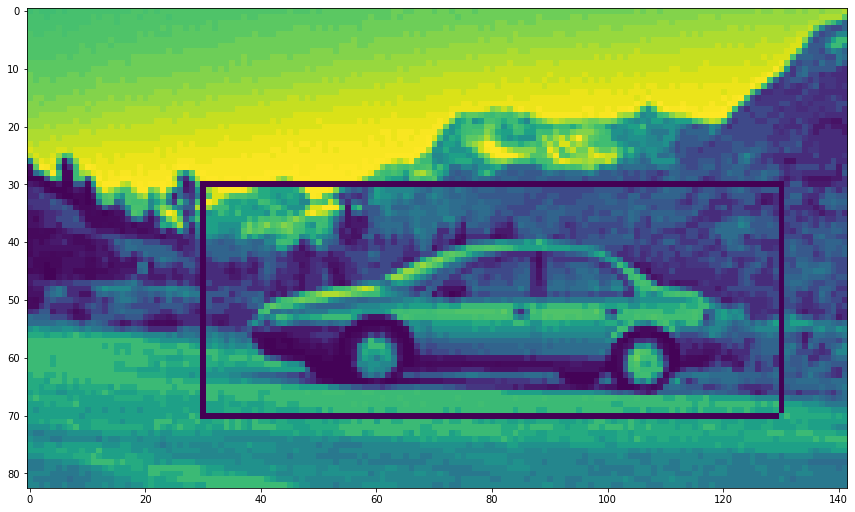

Image No. 48
1 car(s) detected in this image


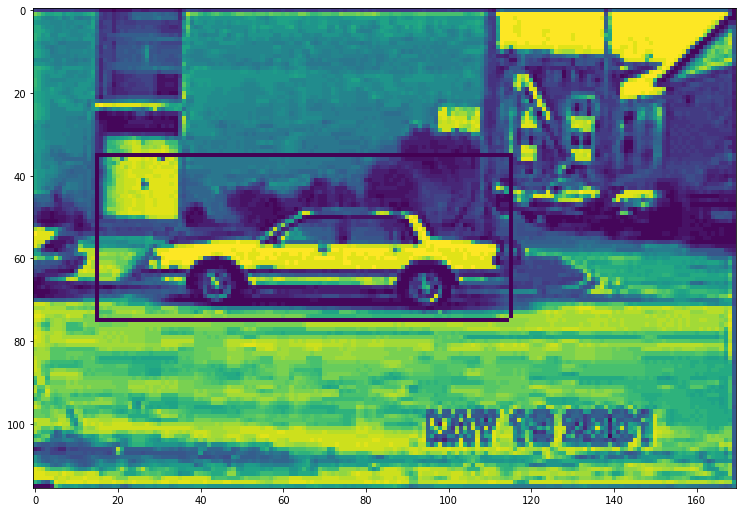

Image No. 49
1 car(s) detected in this image


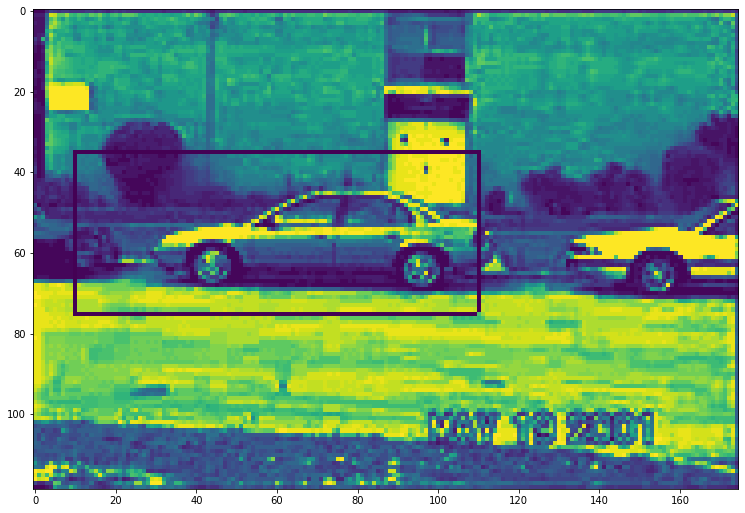

Image No. 50
1 car(s) detected in this image


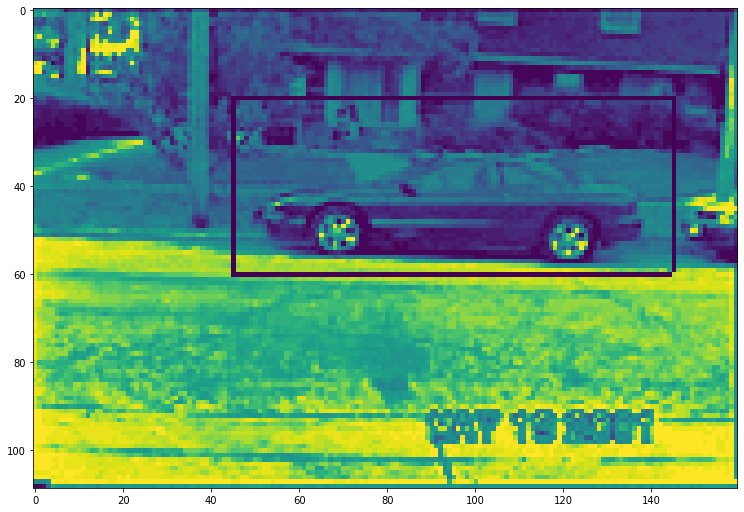

Image No. 51
1 car(s) detected in this image


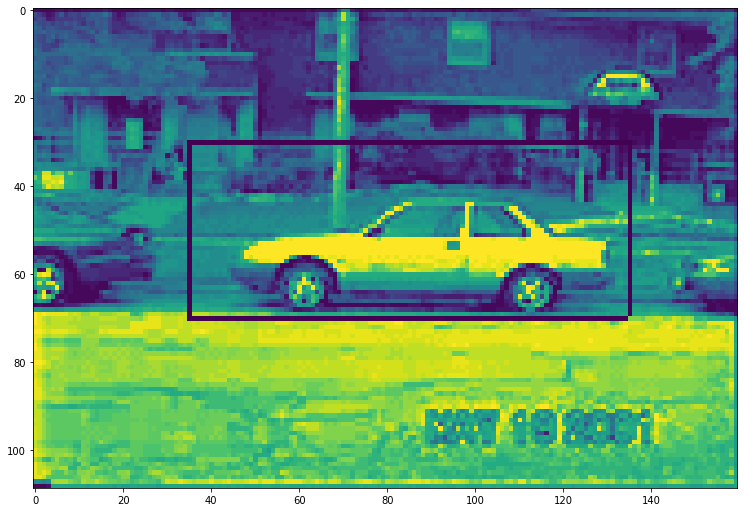

Image No. 52
1 car(s) detected in this image


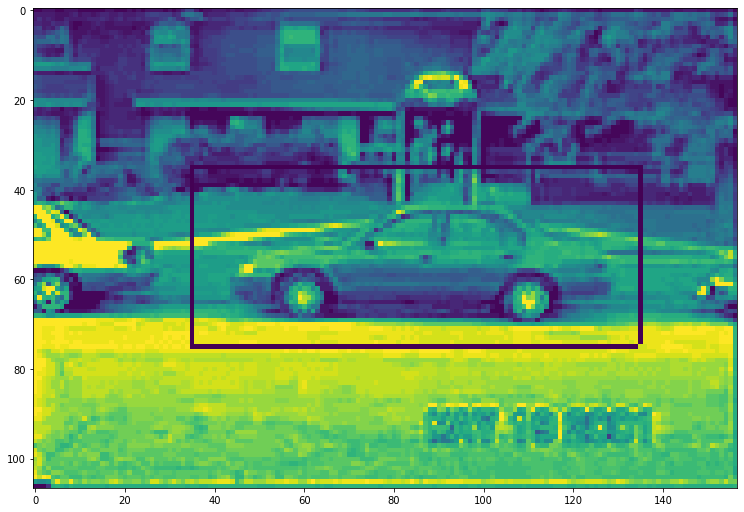

Image No. 53
1 car(s) detected in this image


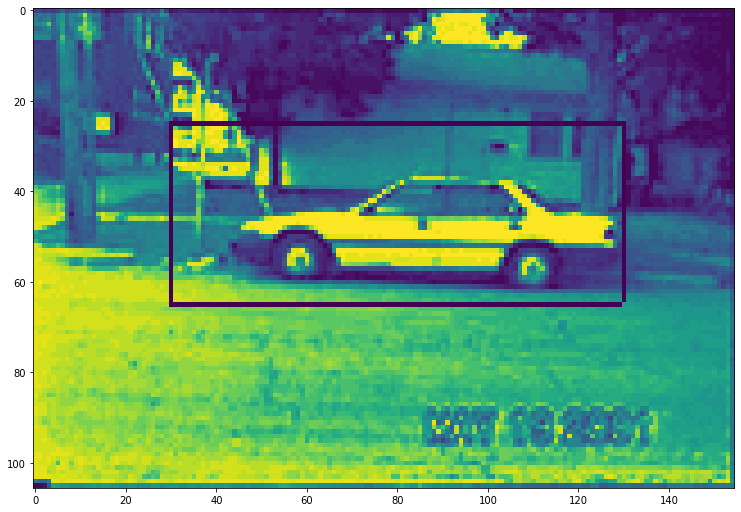

Image No. 54
1 car(s) detected in this image


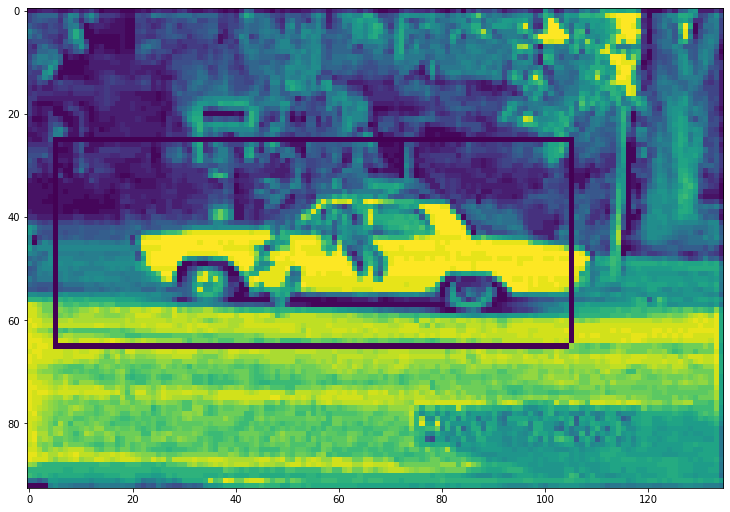

Image No. 55
0 car(s) detected in this image


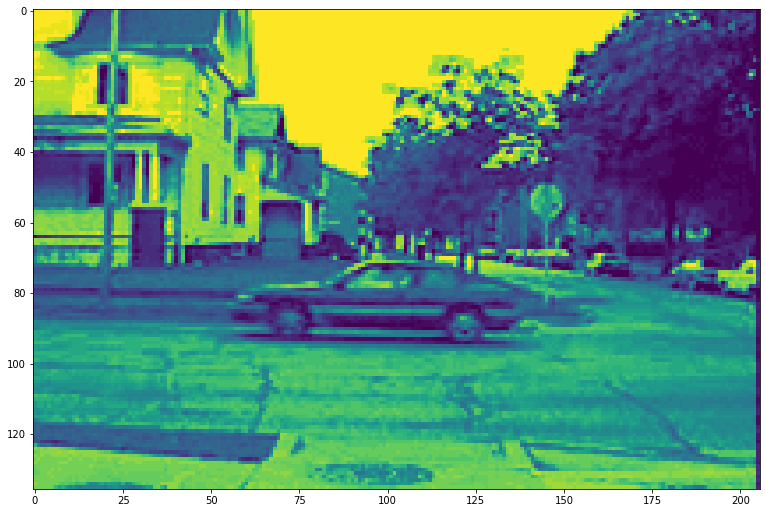

Image No. 56
1 car(s) detected in this image


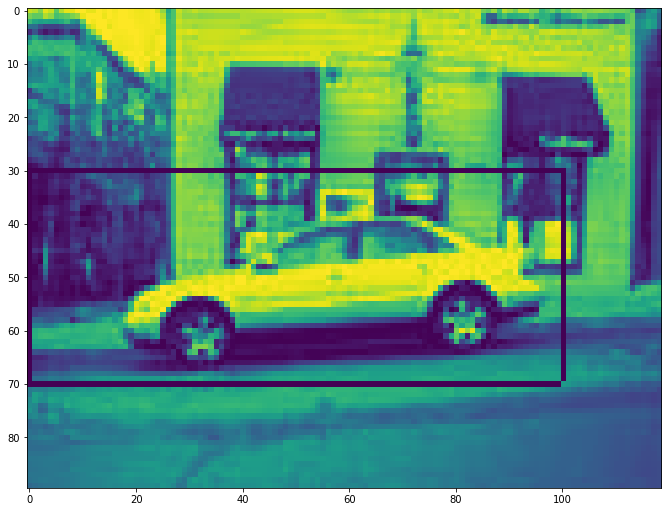

Image No. 57
1 car(s) detected in this image


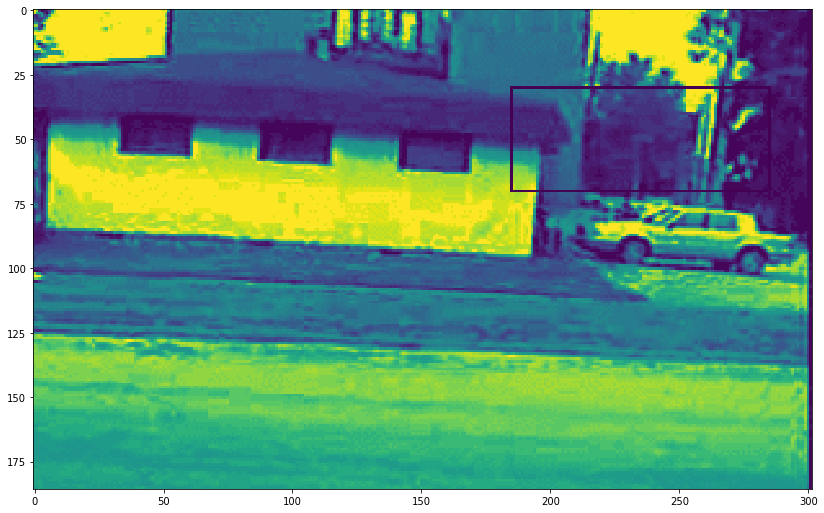

Image No. 58
0 car(s) detected in this image


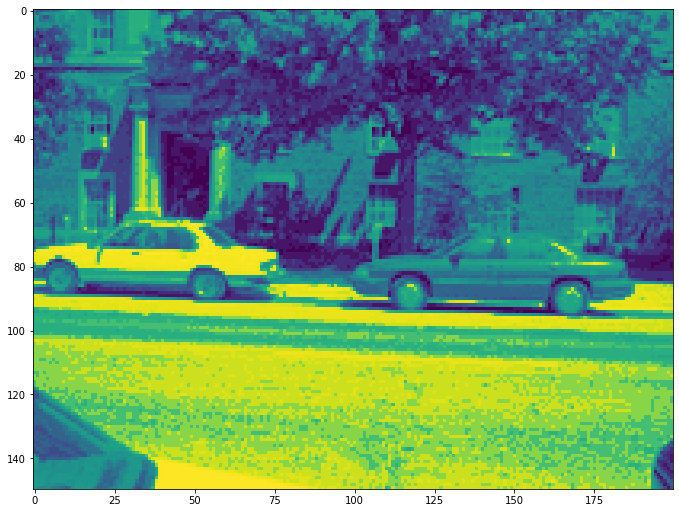

Image No. 59
1 car(s) detected in this image


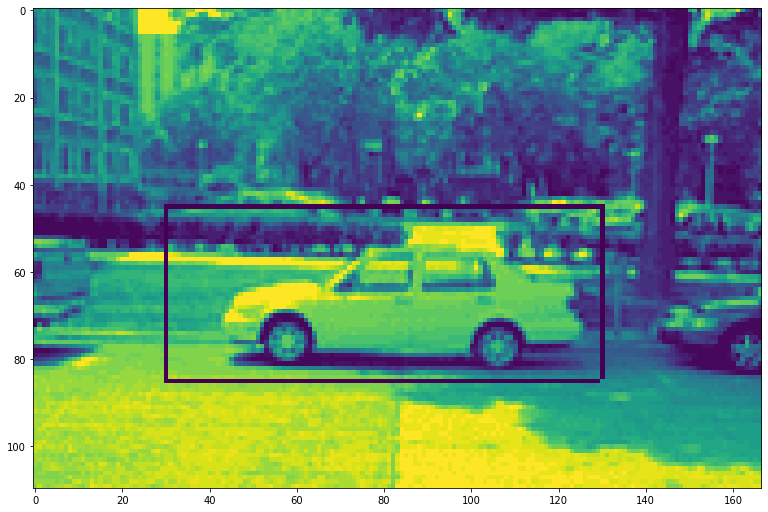

Image No. 60
0 car(s) detected in this image


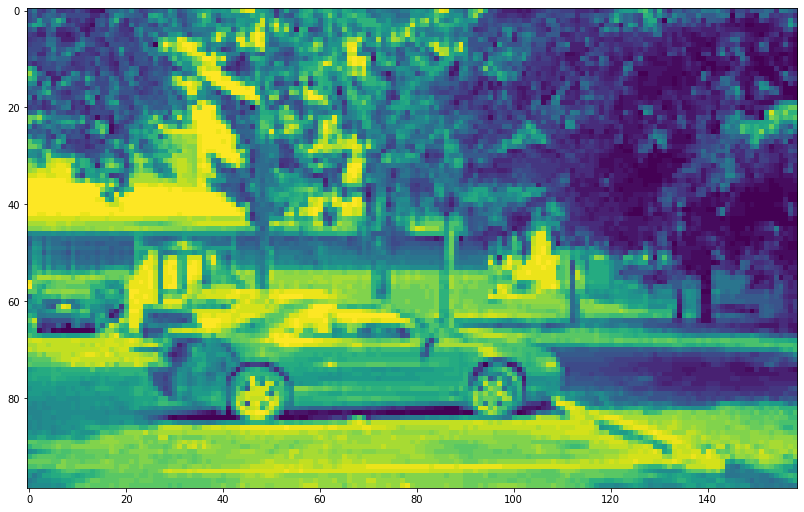

Image No. 61
1 car(s) detected in this image


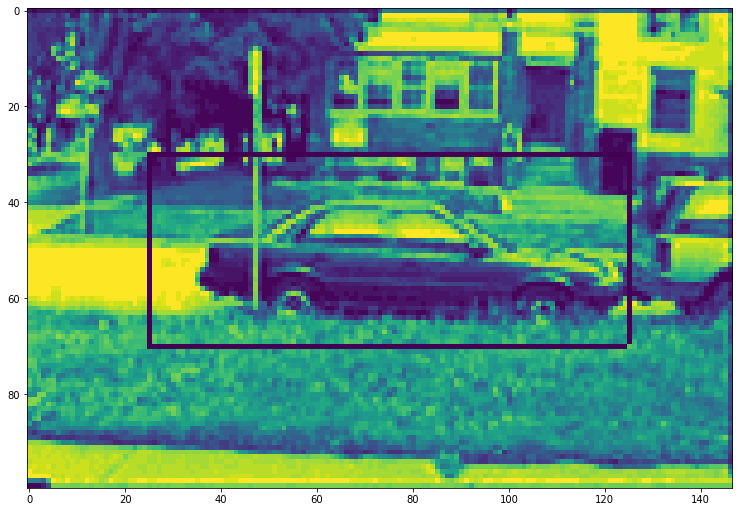

Image No. 62
1 car(s) detected in this image


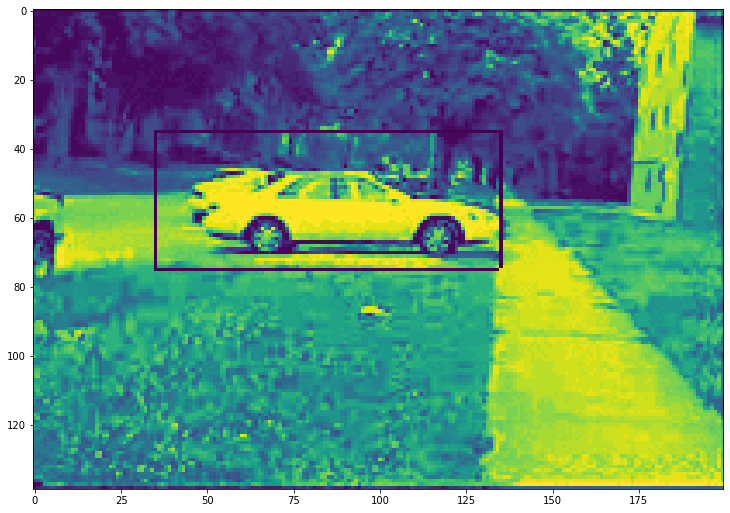

Image No. 63
1 car(s) detected in this image


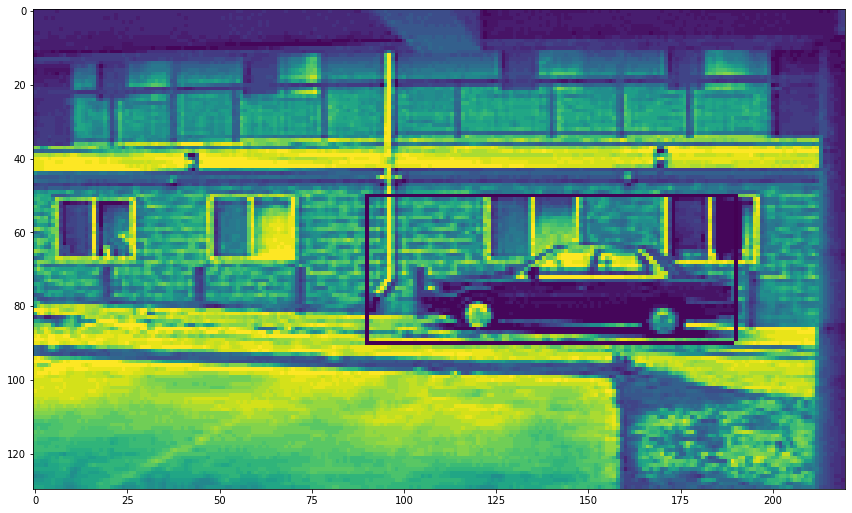

Image No. 64
1 car(s) detected in this image


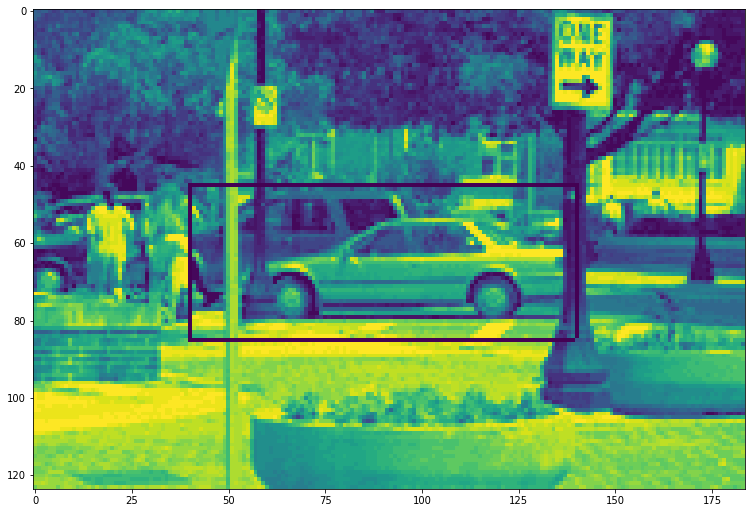

Image No. 65
2 car(s) detected in this image


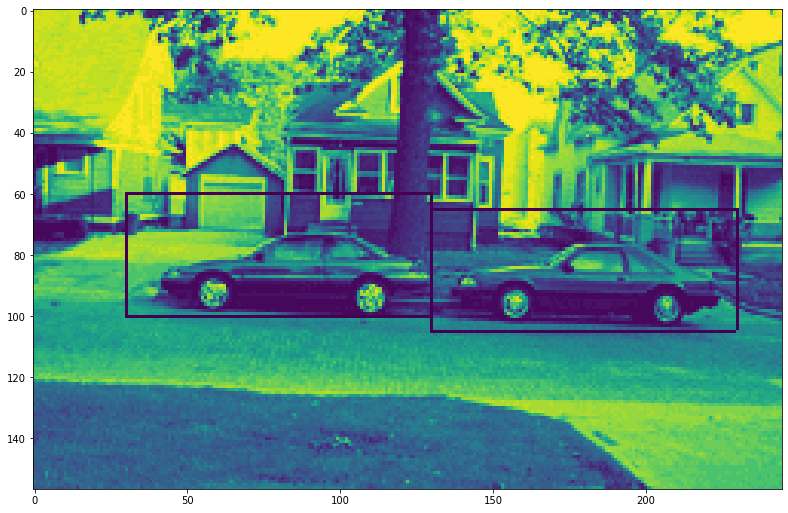

Image No. 66
1 car(s) detected in this image


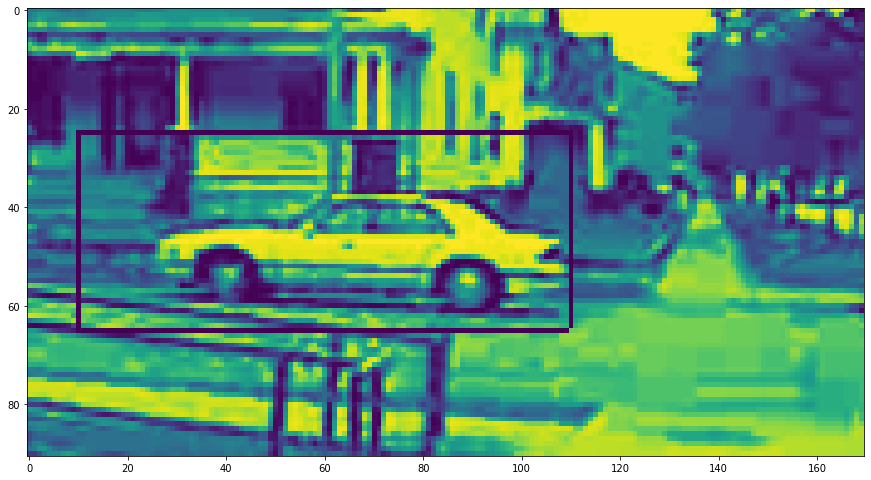

Image No. 67
2 car(s) detected in this image


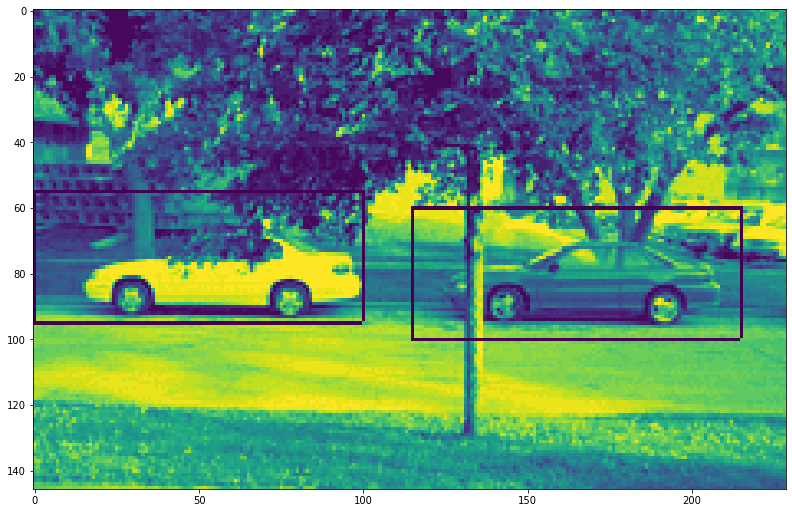

Image No. 68
1 car(s) detected in this image


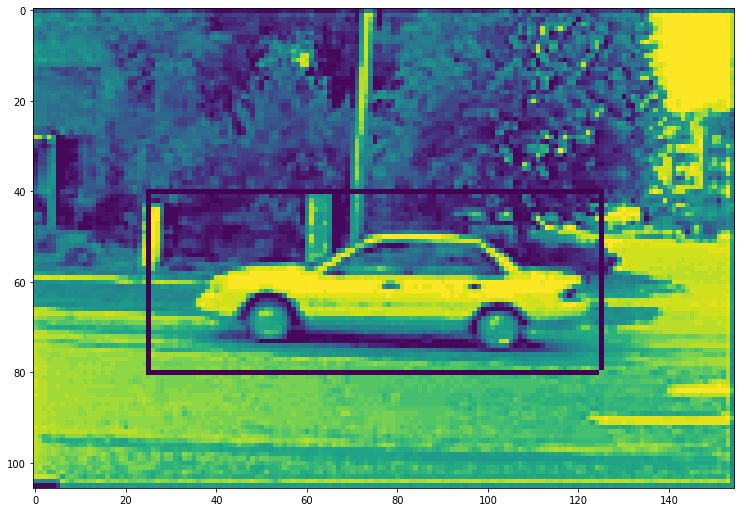

Image No. 69
2 car(s) detected in this image


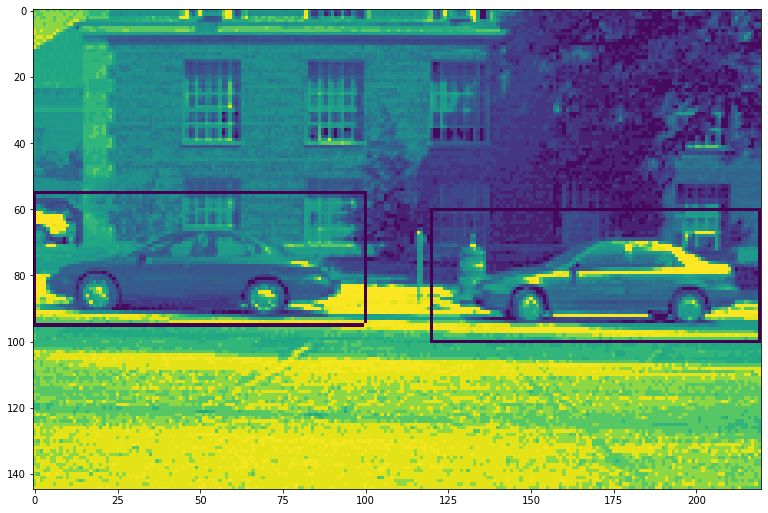

Image No. 70
1 car(s) detected in this image


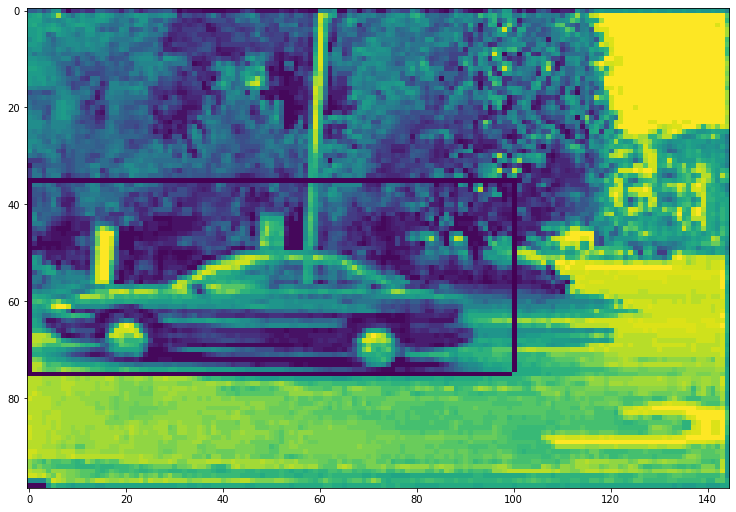

Image No. 71
1 car(s) detected in this image


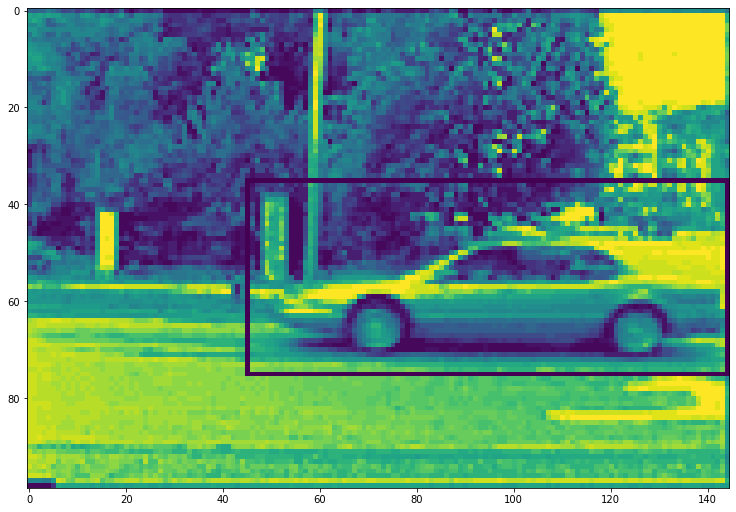

Image No. 72
1 car(s) detected in this image


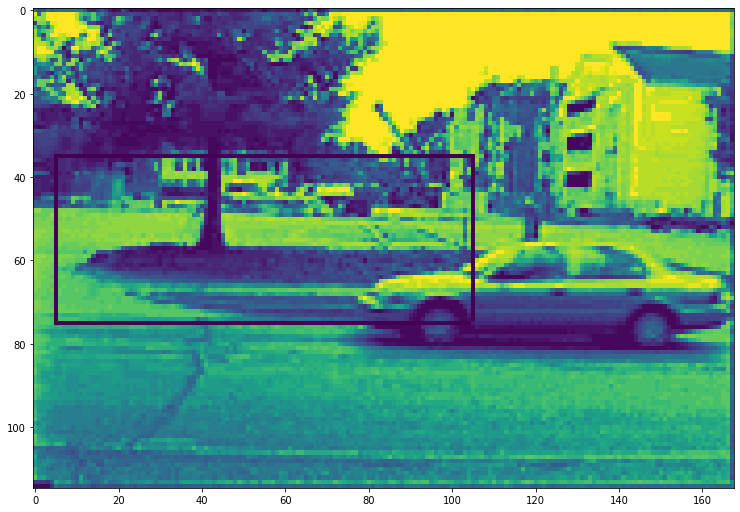

Image No. 73
1 car(s) detected in this image


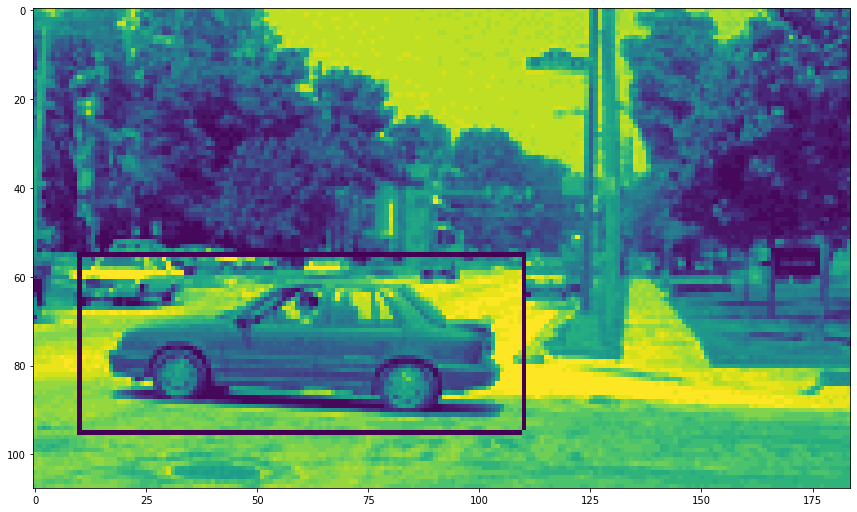

Image No. 74
2 car(s) detected in this image


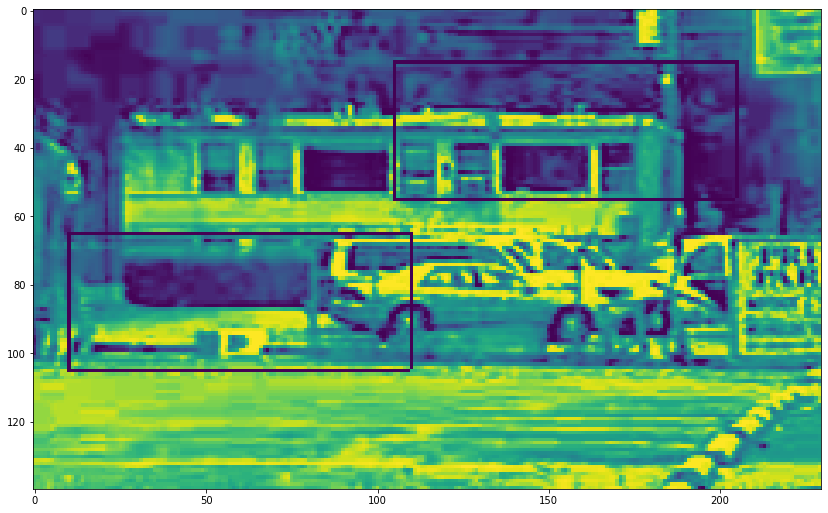

Image No. 75
1 car(s) detected in this image


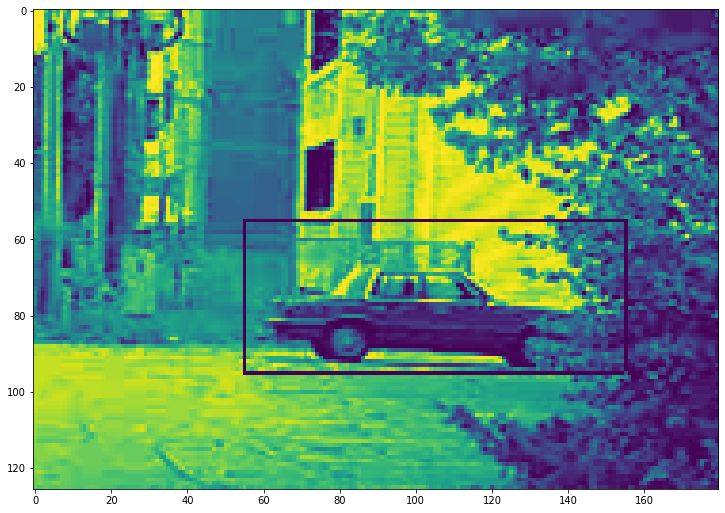

Image No. 76
1 car(s) detected in this image


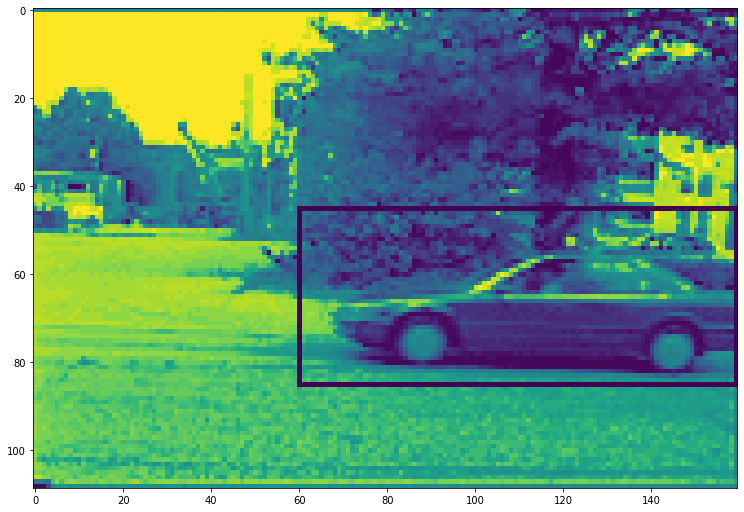

Image No. 77
1 car(s) detected in this image


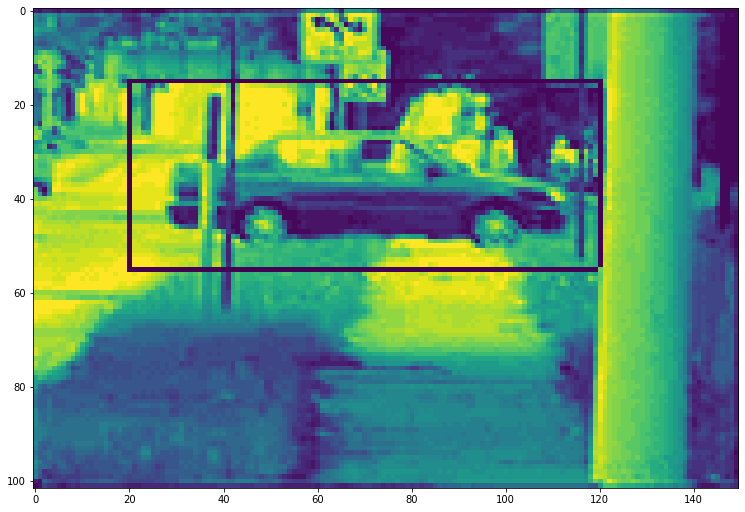

Image No. 78
1 car(s) detected in this image


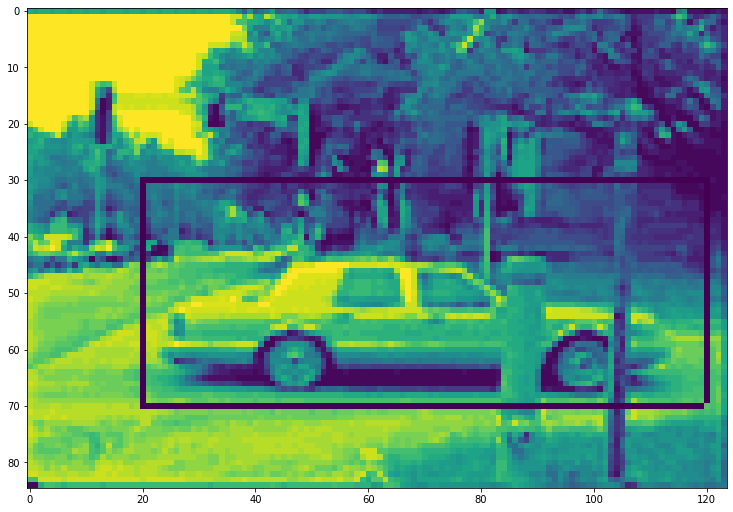

Image No. 79
1 car(s) detected in this image


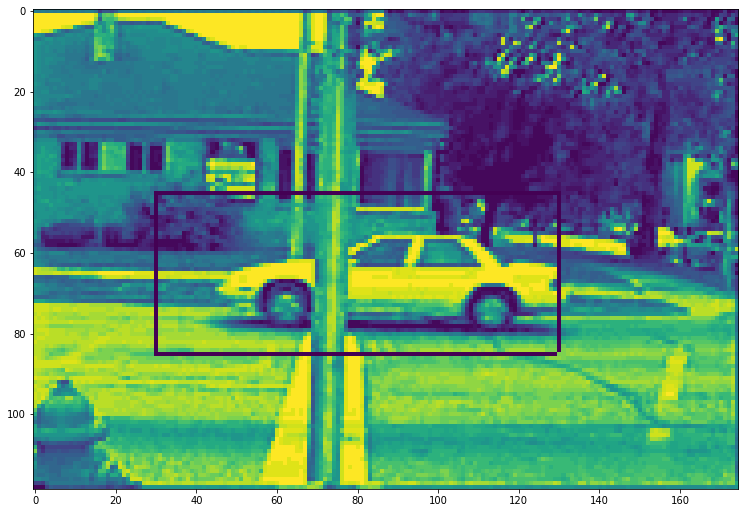

Image No. 80
1 car(s) detected in this image


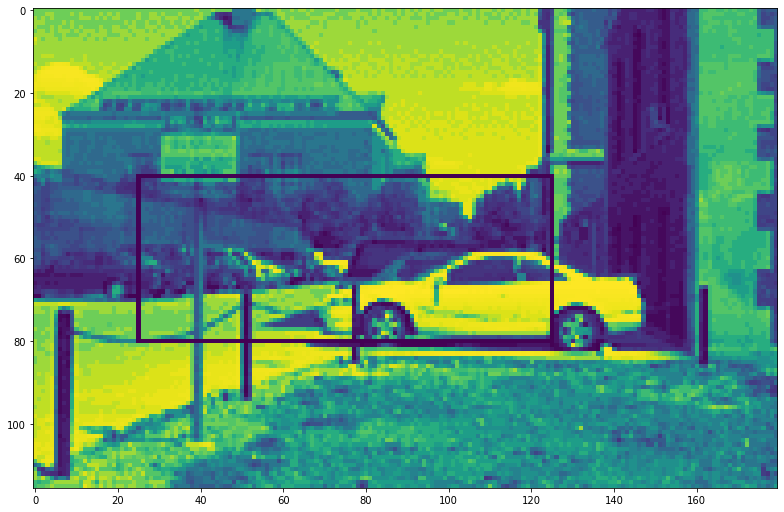

Image No. 81
1 car(s) detected in this image


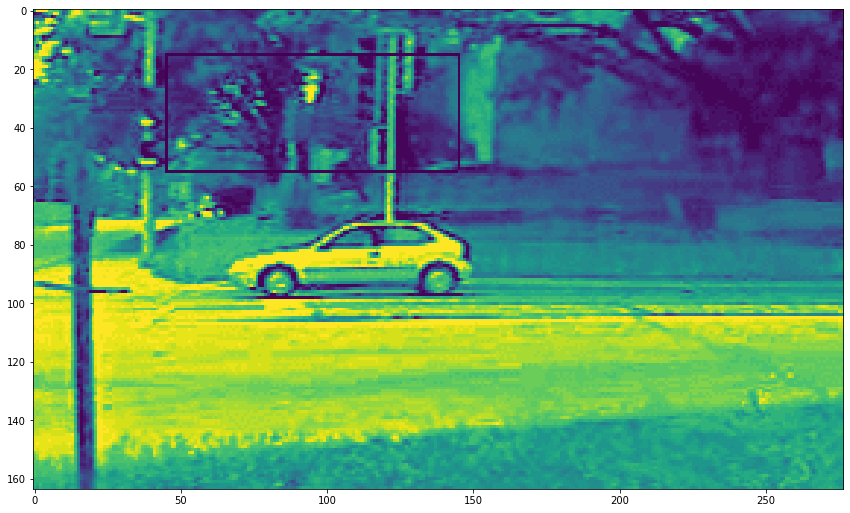

Image No. 82
1 car(s) detected in this image


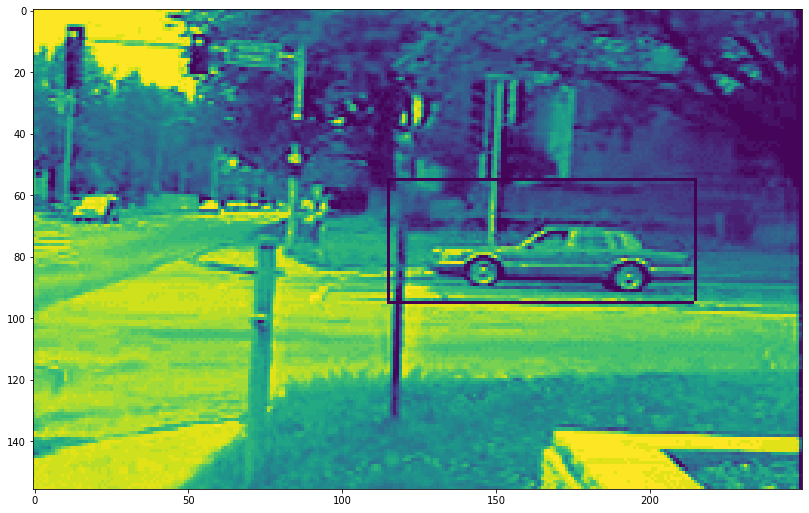

Image No. 83
1 car(s) detected in this image


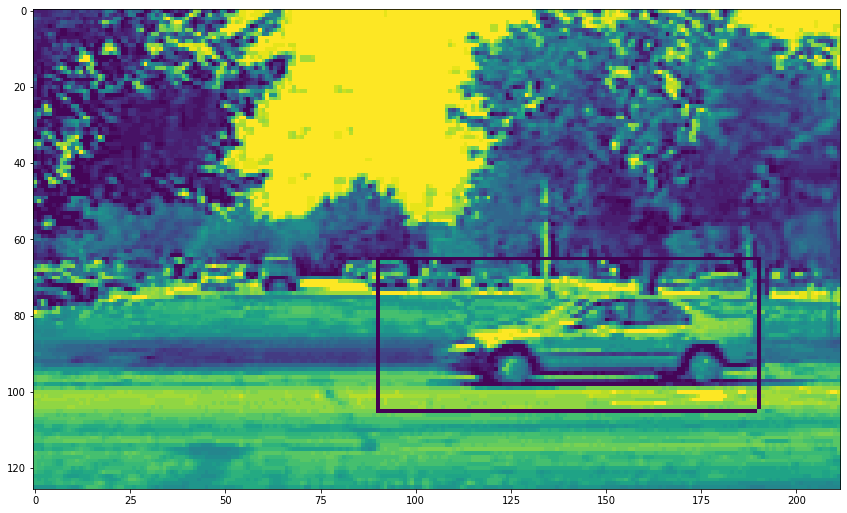

Image No. 84
1 car(s) detected in this image


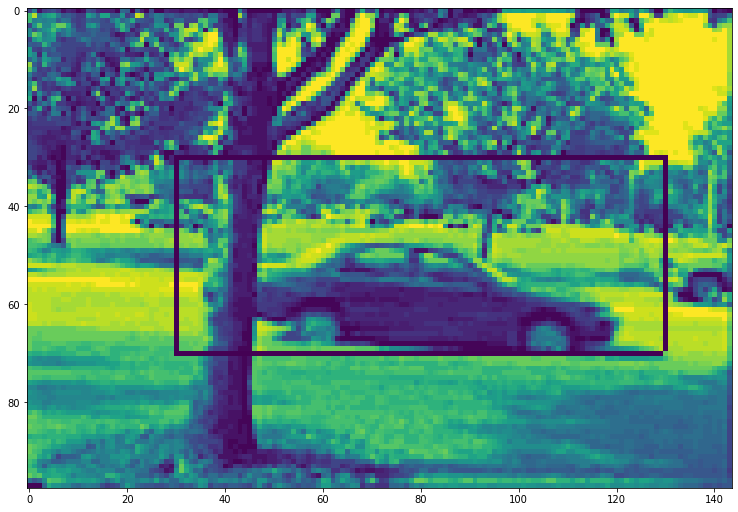

Image No. 85
1 car(s) detected in this image


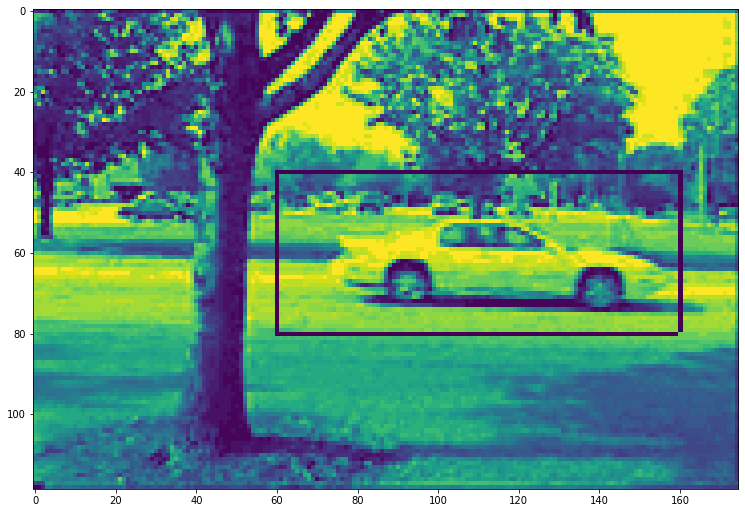

Image No. 86
1 car(s) detected in this image


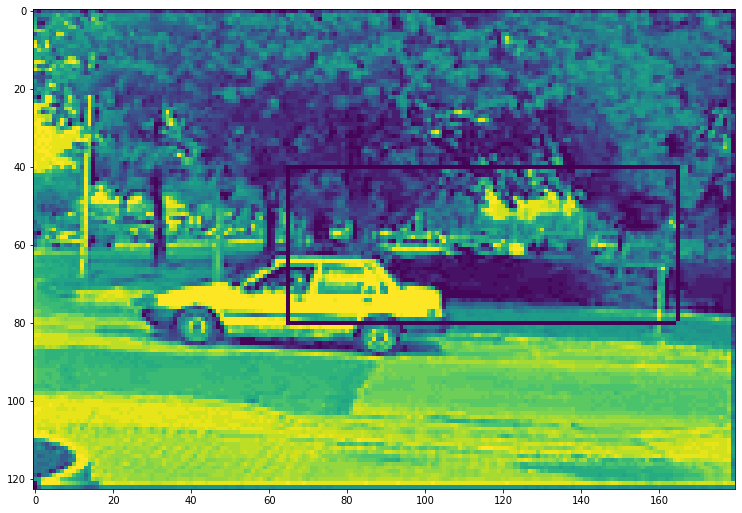

Image No. 87
2 car(s) detected in this image


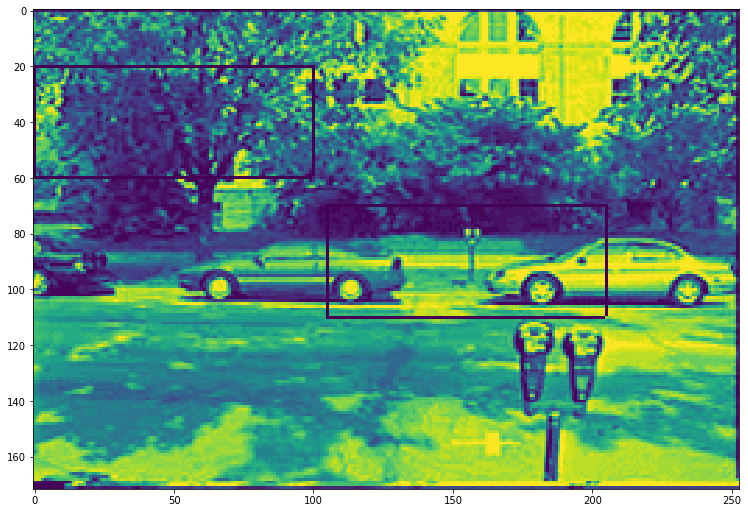

Image No. 88
1 car(s) detected in this image


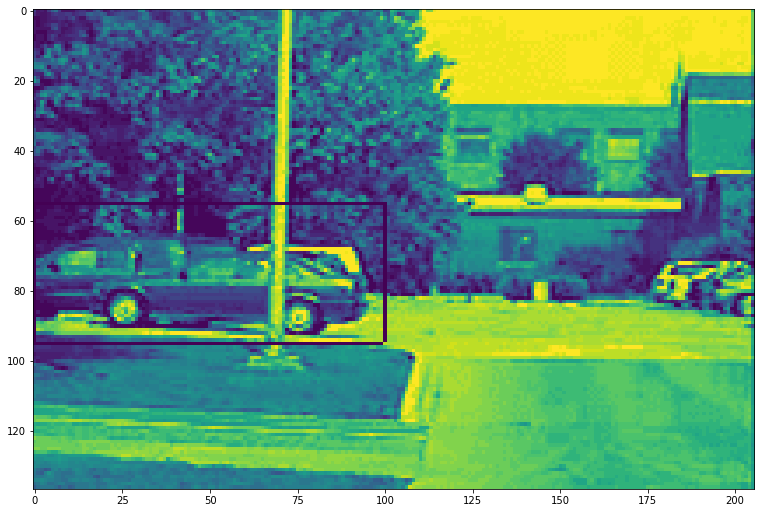

Image No. 89
0 car(s) detected in this image


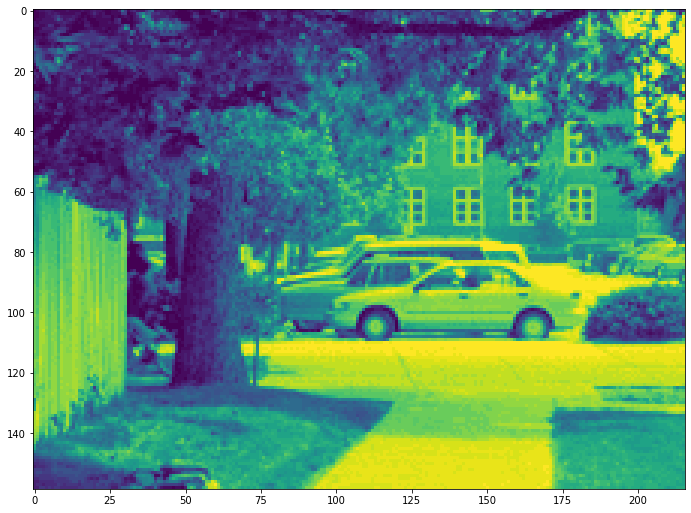

Image No. 90
1 car(s) detected in this image


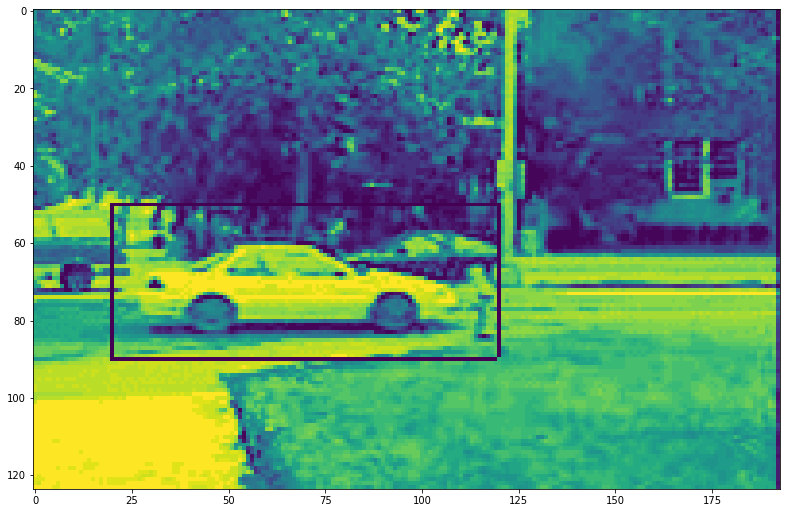

Image No. 91
2 car(s) detected in this image


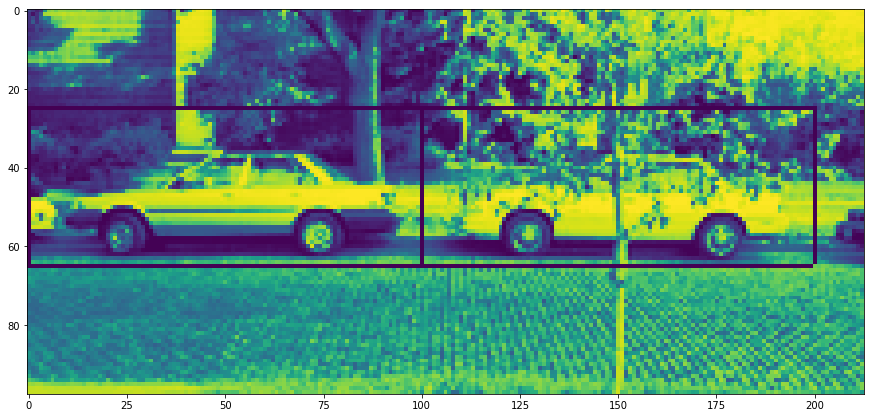

Image No. 92
1 car(s) detected in this image


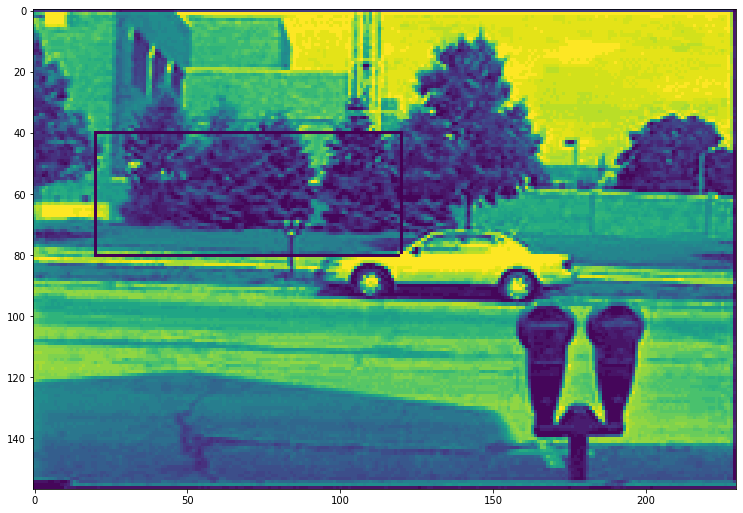

Image No. 93
1 car(s) detected in this image


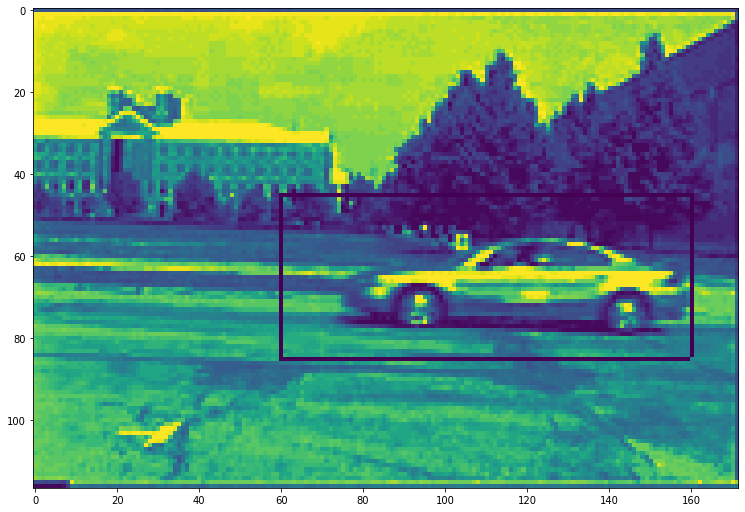

Image No. 94
1 car(s) detected in this image


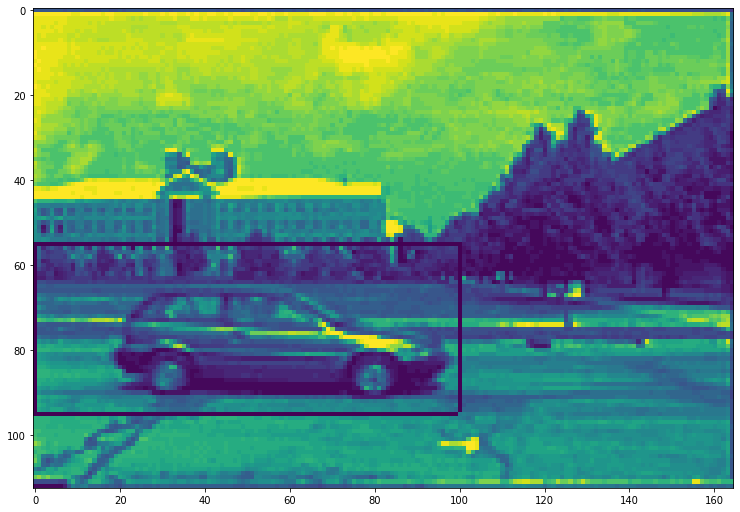

Image No. 95
1 car(s) detected in this image


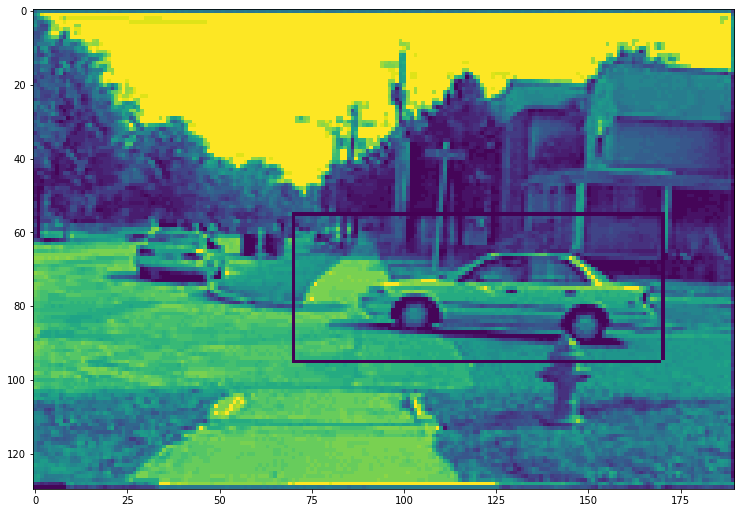

Image No. 96
1 car(s) detected in this image


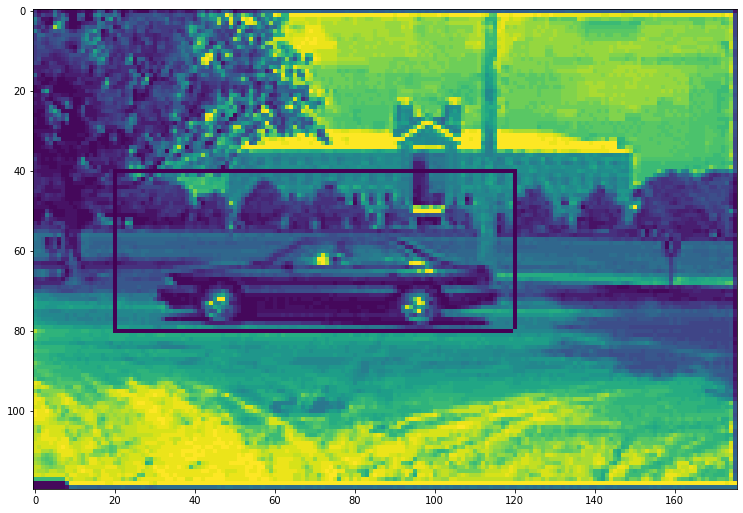

Image No. 97
1 car(s) detected in this image


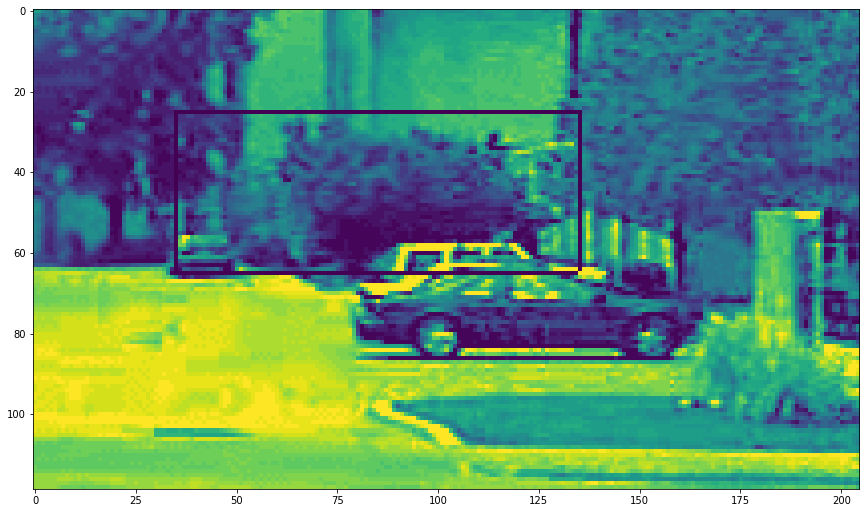

Image No. 98
1 car(s) detected in this image


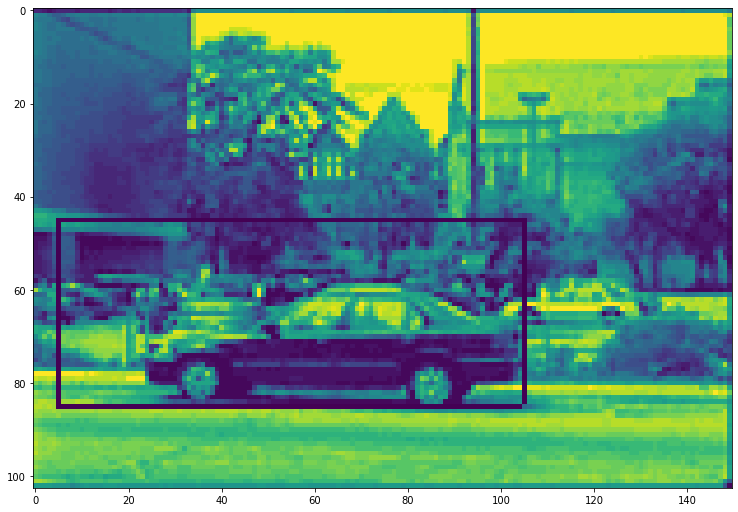

Image No. 99
1 car(s) detected in this image


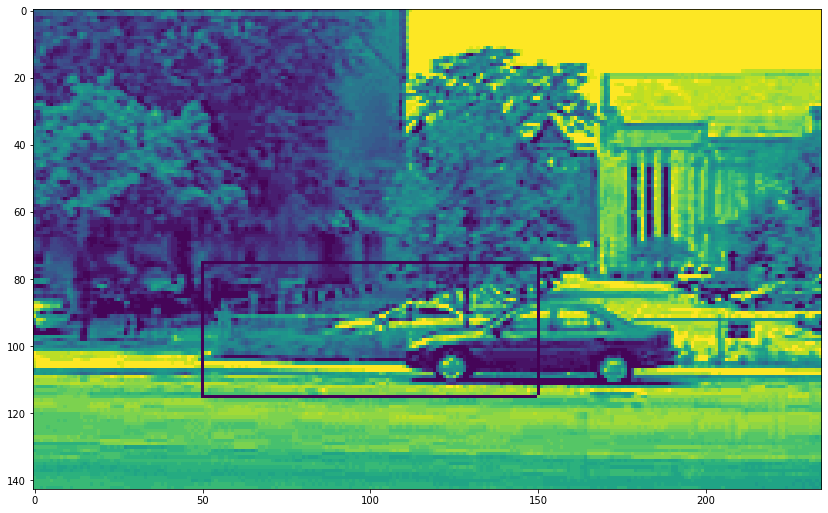

Image No. 100
2 car(s) detected in this image


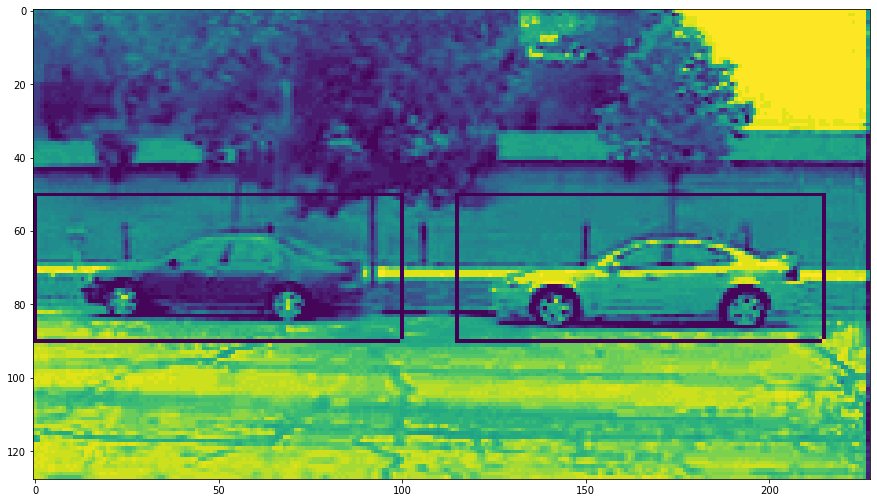

Image No. 101
0 car(s) detected in this image


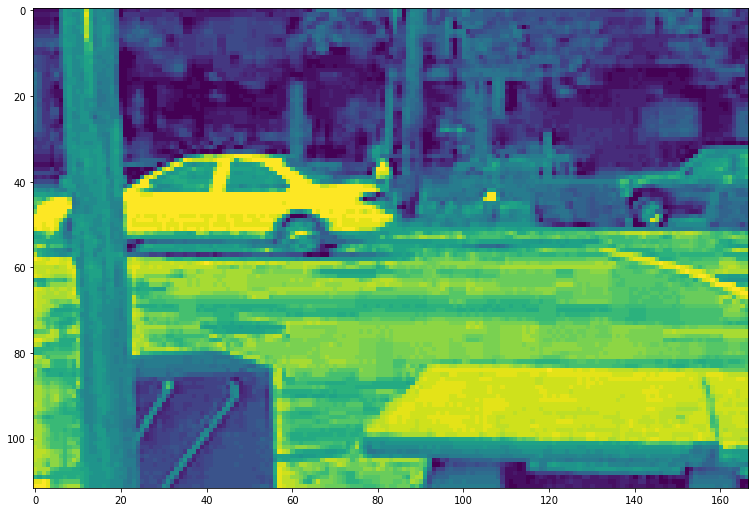

In [160]:
img_folder = "./testCar"

imlist = os.listdir(img_folder)
imlist.sort()
#size = (len(imlist))
counter = 0

for imagename in imlist: 
    imurl = os.path.join(img_folder,imagename)
    im = Image.open(imurl)
    width = im.size[0]
    height = im.size[1]
    picture_tensor = np.zeros([1, width, height, 1])
    for i in range(width):
        for j in range(height):
            gray = im.getpixel((i, j))
            picture_tensor[0, i, j, 0] = gray
    picture_tensor = picture_tensor.transpose(0,2,1,3)
    step = 5
    cars = []
    for y in range(int((width-(100-step))/step)):
        for x in range(int((height-(40-step))/step)):
            area = cutting(x*step, y*step)
            result = model.predict(area)
            if result[0][1]>0.99999  and not_near(x*step,y*step,90, cars): 
                cars.append([[x*step, y*step], result])
    print('Image No.', counter+1)            
    print(len(cars), "car(s) detected in this image")
    for i in cars:
        #print(i[0][0], i[0][1])
        show_car(i[0][0], i[0][1], width, height)
    
    plt.figure(1, figsize = (15, 30))

    plt.subplot(3,1,1)
    plt.imshow(picture_tensor.reshape(height, width))

    plt.show()
    counter = counter + 1 


From the images above we see that although the model finds most of the cars in the testing images, there are stil some missing cars failed to be detected. In most of the cases, cars with **light colors (close to white) can be easily missed**.

I will try to modify the model to make it more acurate.